## Crash indicator (concise)

Same pipeline as Crash_Indicator.ipynb: short titles and descriptions above each section; no long analysis blocks under the plots.


### Setup

Import libraries and set plot style.


In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import linalg
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully")

Libraries loaded successfully


### Code

See code below.


In [116]:
# S&P 500 stocks with long trading history
# Paper uses N=194 stocks from 1985-2016
SP500_TICKERS = [
    'CMCSA', 'DIS', 'F', 'GPC', 'GT', 'HAS', 'HD', 'HRB', 'IPG',
    'LEG', 'LEN', 'LOW', 'MAT', 'MCD', 'NKE', 'SHW', 'TGT',
    'VFC', 'WHR', 'ADM', 'CAG', 'CL', 'CPB', 'CVS', 'GIS', 'HRL',
    'HSY', 'K', 'KMB', 'KO', 'KR', 'MKC', 'MO', 'SYY', 'TAP', 'TSN',
    'WMT', 'APA', 'COP', 'CVX', 'HAL', 'HP', 'MUR',
    'NBR', 'SLB', 'VLO', 'WMB', 'XOM', 'AFL', 'AIG', 'AON',
    'AXP', 'BAC', 'BBT', 'BEN', 'BK', 'CB', 'CINF', 'CMA', 'C', 'EFX',
    'FHN', 'HBAN', 'HST', 'JPM', 'L', 'LNC', 'MMC',
    'MTB', 'PSA', 'SLM', 'TRV', 'USB', 'VNO', 'WFC', 'WY', 'ZION',
    'ABT', 'AET', 'AMGN', 'BAX', 'BDX', 'BMY', 'CAH', 'CI', 'HUM',
    'JNJ', 'LLY', 'MDT', 'MRK', 'SYK', 'THC', 'TMO', 'UNH',
    'AVY', 'BA', 'CAT', 'CMI', 'CSX', 'CTAS', 'DE', 'DHR', 'DOV',
    'EMR', 'ETN', 'EXPD', 'FDX', 'FLS', 'GD', 'GE', 'GLW', 'GWW', 'HON',
    'ITW', 'LMT', 'LUV', 'MAS', 'MMM', 'ROK', 'TXT',
    'UNP', 'AAPL', 'ADI', 'ADP', 'AMAT', 'AMD', 'HPQ',
    'IBM', 'INTC', 'KLAC', 'LRCX', 'MSI', 'MU', 'TXN', 'WDC', 'XRX',
    'AA', 'APD', 'BMS', 'CLF', 'DD', 'ECL', 'FMC', 'IFF', 'IP',
    'NEM', 'PPG', 'VMC', 'T', 'VZ', 'AEP', 'CMS', 'CNP',
    'D', 'DTE', 'ED', 'EIX', 'EQT', 'ETR', 'EXC', 'NEE', 'NI',
    'PNW', 'SO', 'WEC', 'XEL'
]

# Parameters: M=4 days, Δ=2 days shift
START_DATE = '1985-01-02'  # Adjust based on data availability
END_DATE = '2024-12-31'
EPOCH_SIZE = 4  # M = 4 days
SHIFT = 2    # Δ = 2 days

### Data download

Fetch adjusted close prices from yfinance.


In [117]:
def fetch_data(tickers, start_date, end_date):
    print(f"Fetching {len(tickers)} stocks from {start_date} to {end_date}...")
    
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        progress=True,
        auto_adjust=True
    )['Close']
    
    data = data.ffill().bfill()
    data = data.dropna(axis=1)
    data = data.dropna(axis=0)

    print(f"Final: {data.shape[0]} trading days, {data.shape[1]} stocks")
    return data

# Fetch data
prices = fetch_data(SP500_TICKERS, START_DATE, END_DATE)
N_STOCKS = prices.shape[1]
print(f"\nN = {N_STOCKS} stocks")

Fetching 166 stocks from 1985-01-02 to 2024-12-31...


[*****                 11%                       ]  18 of 166 completed$IPG: possibly delisted; no price data found  (1d 1985-01-02 -> 2024-12-31) (Yahoo error = "No data found, symbol may be delisted")
[*********************100%***********************]  166 of 166 completed

3 Failed downloads:
['AET', 'BMS']: TypeError("Invalid value '0' for dtype 'str'. Value should be a string or missing value, got 'int' instead.")
['IPG']: possibly delisted; no price data found  (1d 1985-01-02 -> 2024-12-31) (Yahoo error = "No data found, symbol may be delisted")


Final: 10079 trading days, 163 stocks

N = 163 stocks


### Core metrics

Log returns, correlation matrix, eigen-centrality, entropy.


In [118]:
def compute_log_returns(prices):
    """Compute log returns: r_i(τ) = ln P_i(τ) - ln P_i(τ-1)"""
    return np.log(prices / prices.shift(1)).dropna()

def compute_correlation_matrix(returns):
    """Compute Pearson correlation matrix C with NaN handling."""
    C = np.corrcoef(returns.T)
    C = np.nan_to_num(C, nan=0.0, posinf=1.0, neginf=-1.0)
    C = (C + C.T) / 2
    np.fill_diagonal(C, 1.0)
    
    return C

def correlation_to_A_matrix(C):
    """
    Convert correlation matrix C to matrix A = |C|^2.
    This ensures non-negative entries for Perron-Frobenius theorem.
    Paper uses n=2 (squared).
    """
    return np.abs(C) ** 2

def compute_eigen_centrality(A):
    """
    Compute eigen-centrality from matrix A.
    Returns normalized eigenvector of largest eigenvalue.
    p_i >= 0 and sum(p_i) = 1
    """
    eigenvalues, eigenvectors = linalg.eigh(A)
    # Get eigenvector for largest eigenvalue
    idx_max = np.argmax(eigenvalues)
    v = eigenvectors[:, idx_max]
    # Ensure non-negative (by Perron-Frobenius, should be)
    v = np.abs(v)
    # Normalize so sum = 1
    p = v / np.sum(v)
    return p

def compute_entropy(p):
    """
    Compute Shannon entropy: H = -sum(p_i * ln(p_i))
    """
    p_nonzero = p[p > 1e-12]
    return -np.sum(p_nonzero * np.log(p_nonzero))

### Code

See code below.


In [119]:
def decompose_correlation_matrix(C):
    """
    Decompose C into market mode C_M and group-random mode C_GR.
    
    C = C_M + C_GR
    C_M = λ₁|e₁⟩⟨e₁|  (rank-1 matrix from largest eigenvalue)
    C_GR = Σᵢ₌₂ᴺ λᵢ|eᵢ⟩⟨eᵢ|  (all other eigenvalues)
    """
    C = np.nan_to_num(C, nan=0.0, posinf=1.0, neginf=-1.0)
    C = (C + C.T) / 2
    np.fill_diagonal(C, 1.0)
    eigenvalues, eigenvectors = linalg.eigh(C)
    
    # Sort by eigenvalue (descending)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    N = len(eigenvalues)
    
    # Market mode: C_M = λ₁ * |e₁⟩⟨e₁|
    e1 = eigenvectors[:, 0].reshape(-1, 1)
    C_M = eigenvalues[0] * (e1 @ e1.T)
    
    # Group-Random mode: C_GR = sum over i=2 to N
    C_GR = np.zeros_like(C)
    for i in range(1, N):
        ei = eigenvectors[:, i].reshape(-1, 1)
        C_GR += eigenvalues[i] * (ei @ ei.T)
    
    return C_M, C_GR, eigenvalues, eigenvectors

def compute_three_entropies(C):
    """
    Compute all three entropies as in the paper:
    - H: from full correlation matrix C
    - H_M: from market mode C_M
    - H_GR: from group-random mode C_GR
    """
    # Decompose C
    C_M, C_GR, eigenvalues, eigenvectors = decompose_correlation_matrix(C)
    
    # Convert to A matrices (squared entries)
    A = correlation_to_A_matrix(C)
    A_M = correlation_to_A_matrix(C_M)
    A_GR = correlation_to_A_matrix(C_GR)
    
    # Compute eigen-centralities
    p = compute_eigen_centrality(A)
    p_M = compute_eigen_centrality(A_M)
    p_GR = compute_eigen_centrality(A_GR)
    
    # Compute entropies
    H = compute_entropy(p)
    H_M = compute_entropy(p_M)
    H_GR = compute_entropy(p_GR)
    
    return H, H_M, H_GR, eigenvalues

### Rolling analysis

Rolling-window entropy and correlation time series.


In [120]:
def rolling_window_analysis(returns_df, epoch_size=40, shift=20):
    """
    Perform rolling window analysis following the paper exactly.
    Computes H, H_M, H_GR for each epoch.
    """
    returns = returns_df.values
    dates = returns_df.index
    N = returns.shape[1]
    H_max = np.log(N)  # Wishart limit
    
    results = []
    start = 0
    
    while start + epoch_size <= len(returns):
        epoch_returns = returns[start:start + epoch_size]
        epoch_end_date = dates[start + epoch_size - 1]
        
        # Correlation matrix
        C = compute_correlation_matrix(epoch_returns)
        
        # Three entropies (paper's method)
        H, H_M, H_GR, eigenvalues = compute_three_entropies(C)
        
        # Mean market correlation μ
        upper_tri = np.triu_indices(N, k=1)
        mu = np.mean(C[upper_tri])
        
        # Phase space coordinates
        H_minus_HM = H - H_M
        H_minus_HGR = H - H_GR
        HM_minus_HGR = H_M - H_GR
        
        # Largest eigenvalue
        lambda_max = eigenvalues[0]
        
        results.append({
            'date': epoch_end_date,
            'H': H,
            'H_M': H_M,
            'H_GR': H_GR,
            'H_max': H_max,
            'H_minus_HM': H_minus_HM,
            'H_minus_HGR': H_minus_HGR,
            'HM_minus_HGR': HM_minus_HGR,
            'abs_H_minus_HM': np.abs(H_minus_HM),
            'abs_H_minus_HGR': np.abs(H_minus_HGR),
            'mu': mu,  # mean correlation
            'lambda_max': lambda_max,
        })
        
        start += shift
        
    return pd.DataFrame(results)
    
# Compute returns
returns = compute_log_returns(prices)
results = rolling_window_analysis(returns, epoch_size=EPOCH_SIZE, shift=SHIFT)

print(results)

           date         H       H_M      H_GR    H_max  H_minus_HM  \
0    1985-01-08  5.050599  4.667692  4.892959  5.09375    0.382907   
1    1985-01-10  5.016929  4.775645  4.812094  5.09375    0.241284   
2    1985-01-14  5.037093  4.773765  4.858237  5.09375    0.263328   
3    1985-01-16  5.062982  4.714919  4.870383  5.09375    0.348063   
4    1985-01-18  5.073628  4.677586  4.944516  5.09375    0.396042   
...         ...       ...       ...       ...      ...         ...   
5033 2024-12-17  5.083985  4.726571  4.920806  5.09375    0.357414   
5034 2024-12-19  5.018781  4.925420  4.777176  5.09375    0.093362   
5035 2024-12-23  5.030527  4.998109  4.511133  5.09375    0.032418   
5036 2024-12-26  5.015023  4.861588  4.727637  5.09375    0.153434   
5037 2024-12-30  5.032624  4.990466  4.609315  5.09375    0.042158   

      H_minus_HGR  HM_minus_HGR  abs_H_minus_HM  abs_H_minus_HGR        mu  \
0        0.157640     -0.225267        0.382907         0.157640  0.030171   
1  

### Pre/Post-2005 split

Split results and create pre-2005 and post-2005 plots.


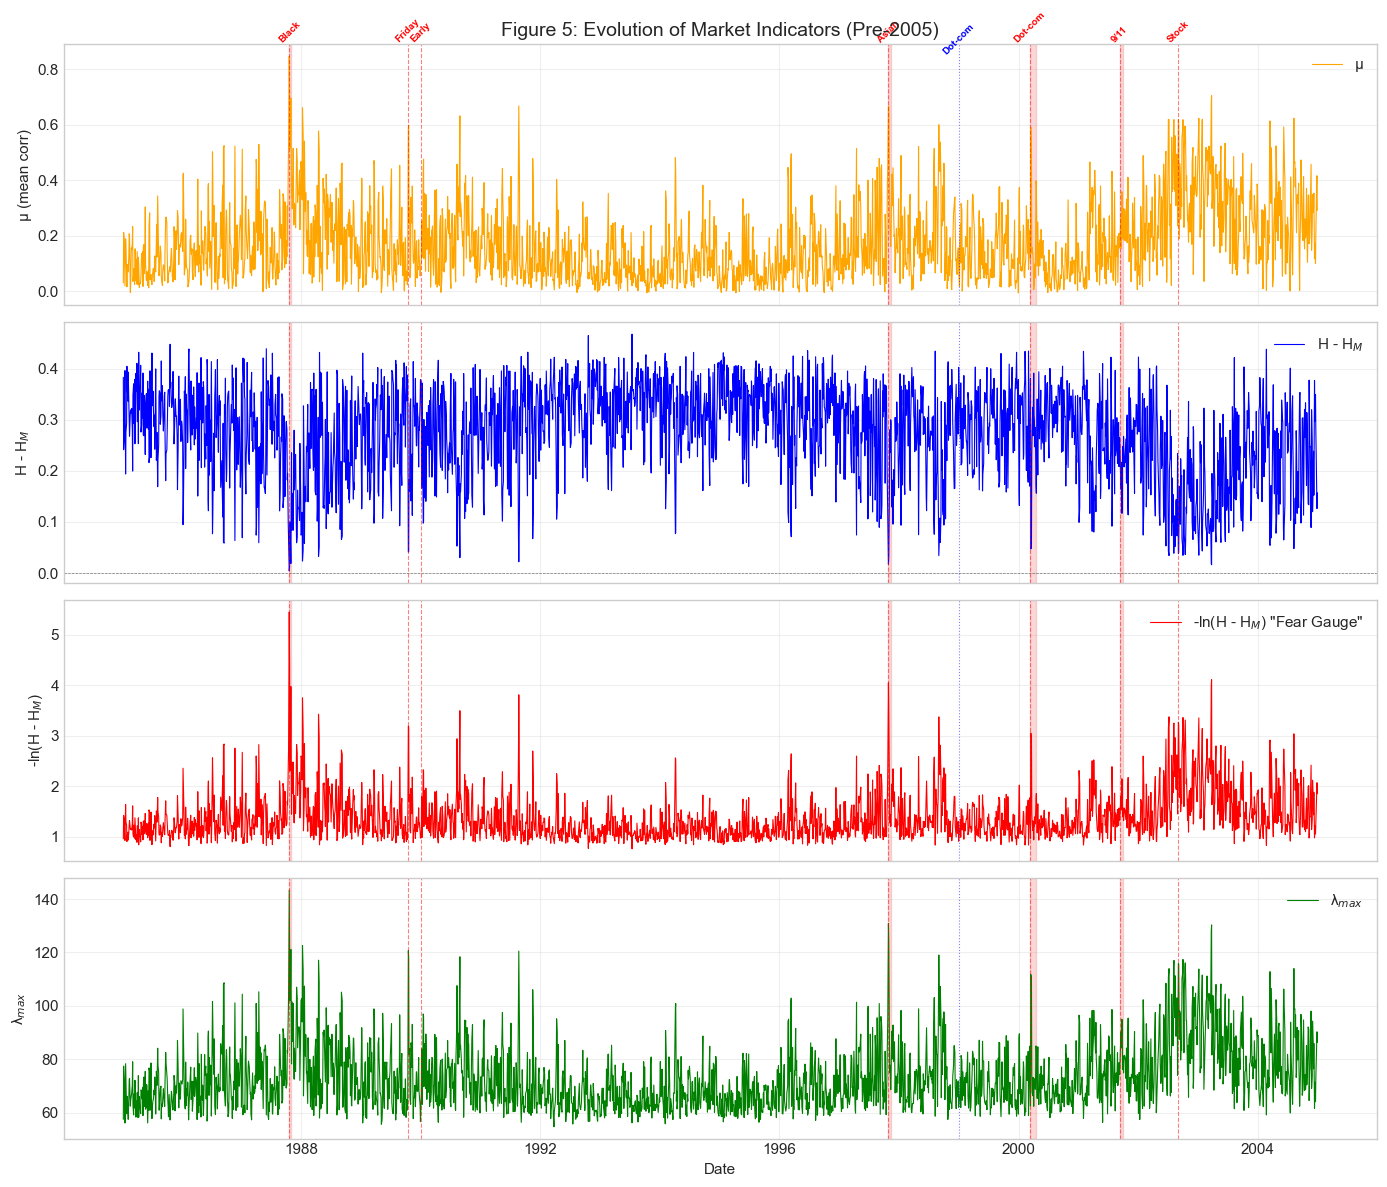

In [121]:
# Split data into pre-2005 and post-2005
split_date = pd.Timestamp('2005-01-01')
results_pre2005 = results[results['date'] < split_date].copy()
results_post2005 = results[results['date'] >= split_date].copy()

MARKET_EVENTS = {
    'crashes': [
        # Pre-2000 events (from paper's Table S3)
        ('1987-10-19', '1987-10-30', 'Black Monday'),
        ('1989-10-13', '1989-10-20', 'Friday 13th Mini Crash'),
        ('1990-01-01', '1990-12-31', 'Early 90s Recession'),
        ('1997-10-27', '1997-11-15', 'Asian Financial Crisis'),
        # 2000s events
        ('2000-03-10', '2000-04-14', 'Dot-com Crash'),
        ('2001-09-11', '2001-09-30', '9/11 Financial Crisis'),
        ('2002-09-01', '2002-10-15', 'Stock Market Downturn 2002'),
        ('2008-09-15', '2008-11-30', 'Lehman Brothers Crash'),
        ('2010-05-06', '2010-05-20', 'DJ Flash Crash'),
        ('2011-03-11', '2011-03-25', 'Tsunami/Fukushima'),
        ('2011-08-08', '2011-08-31', 'August 2011 Markets Fall'),
        ('2015-08-24', '2015-09-15', 'Chinese Black Monday'),
        ('2018-02-02', '2018-02-09', 'Volatility spike'),
        ('2020-02-20', '2020-03-23', 'COVID Crash'),
    ],
    'bubbles': [
        ('1999-01-01', '2000-03-09', 'Dot-com Bubble'),
        ('2005-01-01', '2007-10-01', 'US Housing Bubble'),
        ('2021-01-01', '2021-11-15', 'Post-COVID Rally'),
    ]
}

# Filter events by date
def filter_events_by_date(events_dict, split_date, before=True):
    """Filter events to only include those before or after split_date"""
    filtered = {'crashes': [], 'bubbles': []}
    for event_type in ['crashes', 'bubbles']:
        for start, end, name in events_dict[event_type]:
            event_start = pd.Timestamp(start)
            if (before and event_start < split_date) or (not before and event_start >= split_date):
                filtered[event_type].append((start, end, name))
    return filtered

events_pre2005 = filter_events_by_date(MARKET_EVENTS, split_date, before=True)
events_post2005 = filter_events_by_date(MARKET_EVENTS, split_date, before=False)

# Crisis periods for shading (split by date)
crisis_periods_pre2005 = [
    ('1987-10-19', '1987-10-30', 'Black Monday'),
    ('1997-10-27', '1997-11-15', 'Asian Crisis'),
    ('2000-03-10', '2000-04-14', 'Dot-com Crash'),
    ('2001-09-11', '2001-09-30', '9/11'),
]

crisis_periods_post2005 = [
    ('2008-09-15', '2008-11-30', 'Lehman'),
    ('2011-08-08', '2011-08-31', 'Aug 2011'),
    ('2015-08-24', '2015-09-15', 'China'),
]

# Function to create plots
def create_plots(results_data, events_dict, crisis_periods, title_suffix):
    """
    Create a multi-panel plot visualizing key market indicators and highlight crisis periods.

    Parameters:
        results_data (pd.DataFrame): DataFrame containing columns:
            - 'date': Dates of observations
            - 'mu': Mean correlation values
            - 'H_minus_HM': Difference between H and H_M indicators
            - 'lambda_max': Largest eigenvalue of the correlation matrix
        events_dict (dict): Dictionary with keys 'crashes' and 'bubbles', not used in plotting in this function.
        crisis_periods (list of tuples): Each tuple: (start_date, end_date, label) of crisis periods to shade on the plot.
        title_suffix (str): Text to append to the main plot title.

    Creates a 4x1 subplot showing:
      - Panel 1: Mean correlation μ
      - Panel 2: H - H_M
      - Panel 3: -ln(H - H_M) ("Fear Gauge" similar to VIX)
      - Panel 4: Largest eigenvalue λ_max

    Crisis periods are shaded on each panel.
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
    
    # Panel 1: Mean correlation μ
    ax = axes[0]
    ax.plot(results_data['date'], results_data['mu'], color='orange', linewidth=0.8, label='μ')
    ax.set_ylabel('μ (mean corr)', fontsize=11)
    ax.set_title(f'Figure 5: Evolution of Market Indicators {title_suffix}', fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Panel 2: H - H_M
    ax = axes[1]
    ax.plot(results_data['date'], results_data['H_minus_HM'], color='blue', linewidth=0.8, label='H - H$_M$')
    ax.set_ylabel('H - H$_M$', fontsize=11)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Panel 3: -ln(H - H_M) - "fear gauge" similar to VIX
    ax = axes[2]
    neg_ln = -np.log(results_data['H_minus_HM'].clip(lower=1e-10))
    ax.plot(results_data['date'], neg_ln, color='red', linewidth=0.8, label='-ln(H - H$_M$) "Fear Gauge"')
    ax.set_ylabel('-ln(H - H$_M$)', fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Panel 4: Largest eigenvalue
    ax = axes[3]
    ax.plot(results_data['date'], results_data['lambda_max'], color='green', linewidth=0.8, label='λ$_{max}$')
    ax.set_ylabel('λ$_{max}$', fontsize=11)
    ax.set_xlabel('Date', fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add crisis bands to all panels
    crisis_added = False
    for ax in axes:
        for start, end, name in crisis_periods:
            try:
                if not crisis_added:
                    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                              color='lightcoral', alpha=0.3, label='Crisis Period')
                    crisis_added = True
                else:
                    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                              color='lightcoral', alpha=0.3)
            except:
                pass
        crisis_added = False  # Reset for next panel
    
    # Add vertical lines for all crashes (red dashed lines)
    for start, end, name in events_dict['crashes']:
        try:
            crash_date = pd.Timestamp(start)
            for ax in axes:
                ax.axvline(crash_date, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
            # Add label for every crash (top panel)
            short_name = (name.split()[0] if name.split() else name)[:12]
            axes[0].annotate(short_name, xy=(crash_date, axes[0].get_ylim()[1]), 
                            fontsize=7, ha='center', va='bottom', color='red', 
                            fontweight='bold', rotation=45)
        except:
            pass
    
    # Add vertical lines for all bubbles (blue dashed lines)
    for start, end, name in events_dict['bubbles']:
        try:
            bubble_date = pd.Timestamp(start)
            for ax in axes:
                ax.axvline(bubble_date, color='blue', linestyle=':', linewidth=0.8, alpha=0.5)
            # Add label only to top panel
            short_name = name.split()[0] if len(name.split()) > 0 else name[:8]
            axes[0].annotate(short_name, xy=(bubble_date, axes[0].get_ylim()[1] * 0.95), 
                            fontsize=7, ha='center', va='bottom', color='blue', 
                            fontweight='bold', rotation=45)
        except:
            pass
    
    plt.tight_layout()
    plt.show()

# Create pre-2005 plot
create_plots(results_pre2005, events_pre2005, crisis_periods_pre2005, '(Pre-2005)')


### Code

See code below.


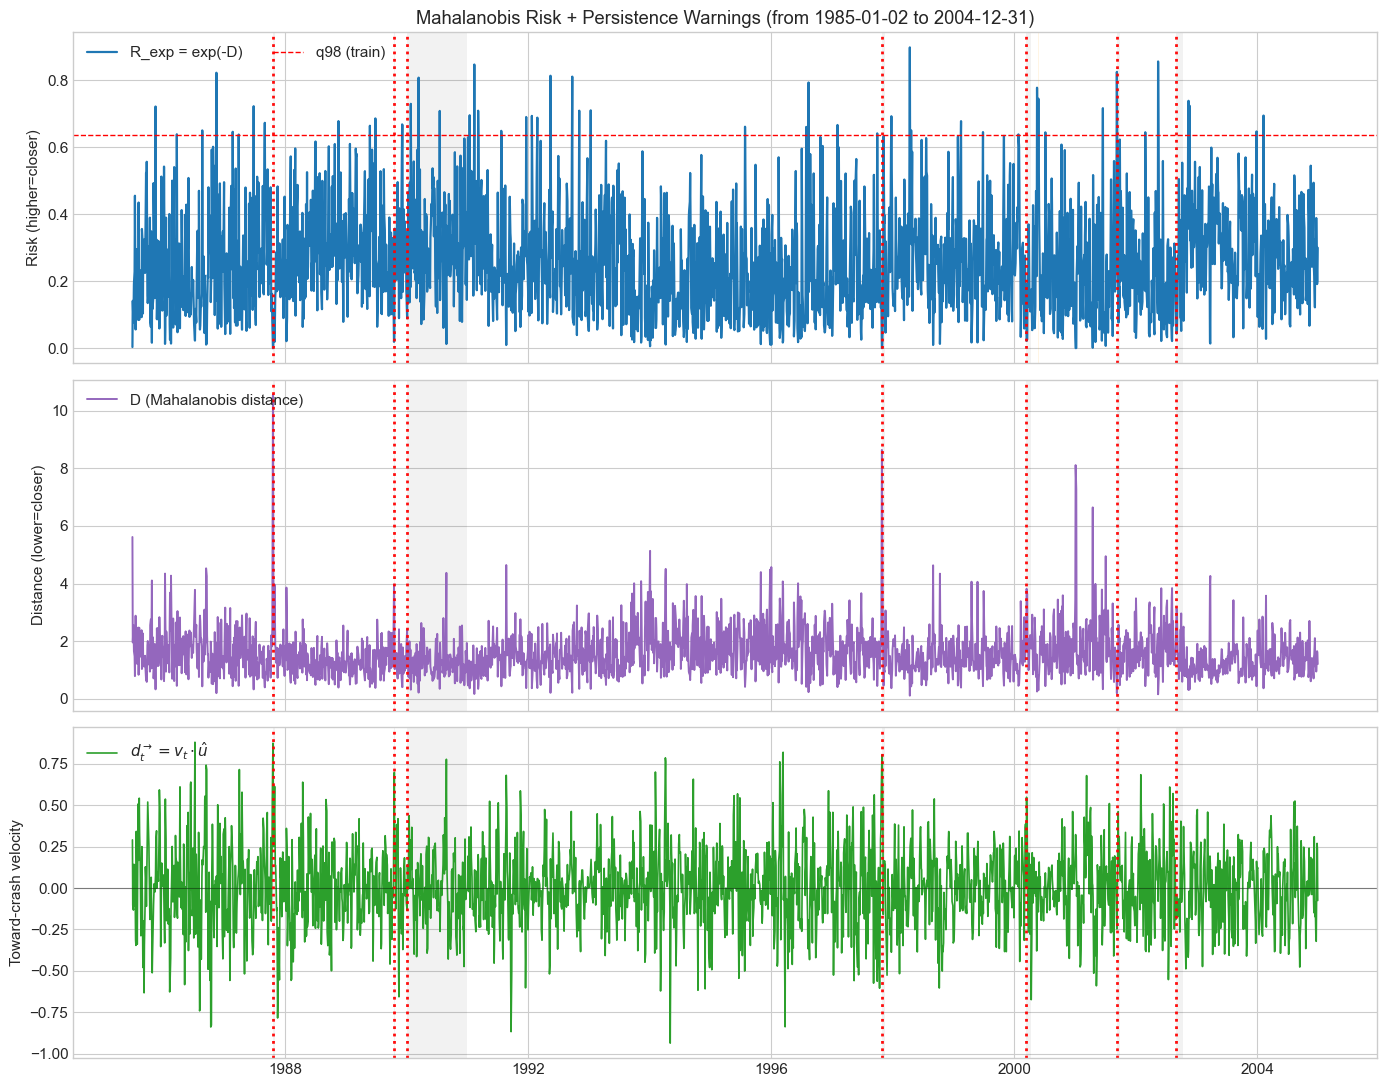

,R_exp,D,d_to,level_persist
date,,,,
2004-11-05,0.472263,0.750218,-0.040936,0
2004-11-09,0.392611,0.934937,0.240512,0
2004-11-11,0.067137,2.701023,-0.040430,0
2004-11-15,0.449321,0.800018,-0.003411,0
2004-11-17,0.385876,0.952240,0.118807,0
2004-11-19,0.544528,0.607836,0.183818,0
2004-11-23,0.325877,1.121235,0.142035,0
2004-11-26,0.242922,1.415017,-0.039469,0
2004-11-30,0.335349,1.092584,0.034918,0


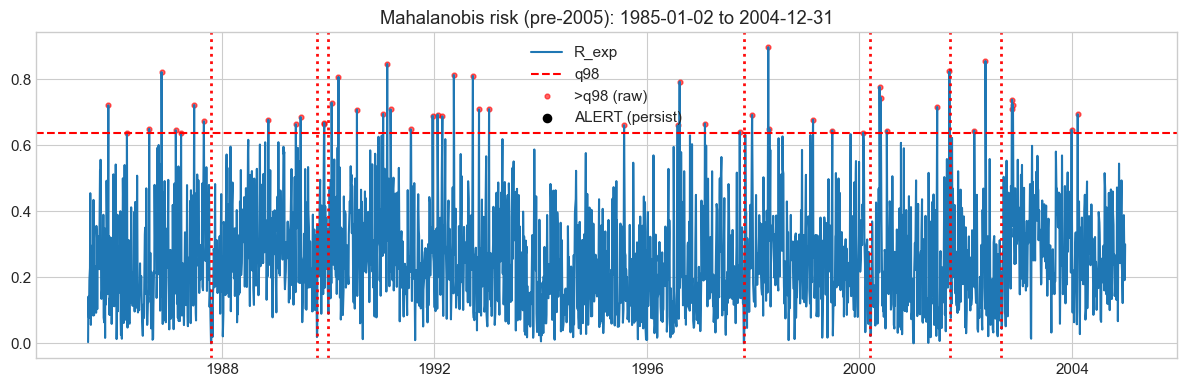

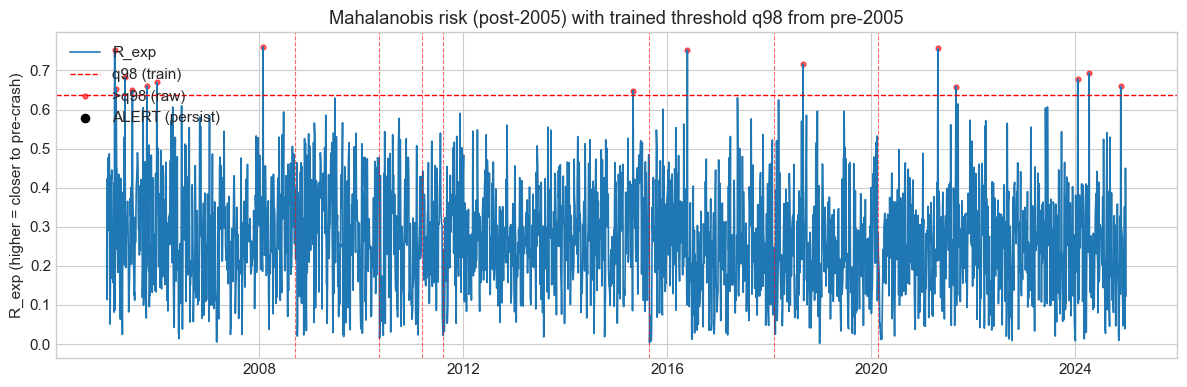

In [153]:
# This cell contains configuration parameters and utility functions for the pre-2005 analysis period.
# It defines constants (such as date ranges and rolling window sizes), 
# a direction vector (u_hat) for transformation or projections,
# and helper functions for:
#   - computing rolling z-scores,
#   - building date masks around crash events,
#   - calculating Mahalanobis distances,
#   - identifying if n out of the last k conditions are met (rolling),
#   - and shading level regions on matplotlib axes.


START_DATE = "1985-01-02"  # start date
SHIFT = 10
ZSCORE_WINDOW = 252  #  z-score window
PRECRASH_L_DAYS = 90
TRAIN_END = "2004-12-31"
PLOT_END  = "2004-12-31"

COL_DATE = "date"
COL_ABSH = "abs_H_minus_HM"
COL_MU   = "mu"
COL_L1   = "lambda_max"

u_hat = np.array([-1.0, +1.0, +1.0])
u_hat = u_hat / np.linalg.norm(u_hat)

def rolling_zscore(s: pd.Series, window: int) -> pd.Series:
    """
    Compute the rolling z-score of a pandas Series.

    Args:
        s (pd.Series): Input series.
        window (int): Window size for rolling calculation.

    Returns:
        pd.Series: Series of rolling z-scores.
    """
    minp = max(20, window // 5)
    m = s.rolling(window, min_periods=minp).mean()
    sd = s.rolling(window, min_periods=minp).std(ddof=0)
    return (s - m) / sd

def build_precrash_mask(index: pd.DatetimeIndex, crashes, L_days: int) -> pd.Series:
    """
    Builds a boolean mask identifying pre-crash periods for a given set of crashes.

    Args:
        index (pd.DatetimeIndex): Date index.
        crashes (iterable): Iterable of (start, end, name) tuples for crash intervals.
        L_days (int): Number of days before each crash to include in the mask.

    Returns:
        pd.Series: Boolean series indexed by the given dates. True if in the pre-crash window.
    """
    mask = pd.Series(False, index=index)
    for start, end, name in crashes:
        t0 = pd.to_datetime(start)
        w0 = t0 - pd.Timedelta(days=L_days)
        mask |= (index >= w0) & (index < t0)
    return mask

def mahalanobis_distance(X: np.ndarray, mu: np.ndarray, Sigma_inv: np.ndarray) -> np.ndarray:
    """
    Compute the Mahalanobis distance of each row in X from the mean mu using provided inverse covariance.

    Args:
        X (np.ndarray): Data array of shape (n_samples, n_features).
        mu (np.ndarray): Mean vector of shape (n_features,).
        Sigma_inv (np.ndarray): Inverse covariance matrix of shape (n_features, n_features).

    Returns:
        np.ndarray: 1D array of Mahalanobis distances.
    """
    d = X - mu
    q = np.einsum("ij,jk,ik->i", d, Sigma_inv, d)
    q = np.maximum(q, 0.0)
    return np.sqrt(q)

def n_out_of_k(condition: pd.Series, n: int, k: int) -> pd.Series:
    """
    Return a boolean Series indicating where at least n out of the last k conditions are True.

    Args:
        condition (pd.Series): Boolean condition series.
        n (int): Minimum number of True observations required.
        k (int): Size of the rolling window.

    Returns:
        pd.Series: Boolean Series of same index as input.
    """
    return condition.rolling(k, min_periods=k).sum() >= n

def shade_levels(ax, idx, levels, alpha=0.10):
    """
    Shade regions on a matplotlib axis according to level values.

    Args:
        ax: Matplotlib Axes object to which to add shaded regions.
        idx (pd.Index): Index corresponding to the levels (typically datetime).
        levels (pd.Series or np.array): Array-like object indicating level values (e.g., 1, 2, 3).
        alpha (float): Transparency factor for shaded regions.

    Returns:
        None
    """
    colors = {1: "gold", 2: "orange", 3: "red"}
    for L in [1, 2, 3]:
        mask = (levels == L)
        if not mask.any():
            continue
        seg = mask.astype(int).diff().fillna(mask.astype(int))
        starts = idx[seg == 1]
        ends   = idx[seg == -1]
        if mask.iloc[0]:
            starts = starts.insert(0, idx[0])
        if mask.iloc[-1]:
            ends = ends.insert(len(ends), idx[-1])
        for s, e in zip(starts, ends):
            ax.axvspan(s, e, color=colors[L], alpha=alpha, lw=0)


# Prep + enforce start date
r = results.copy()
r[COL_DATE] = pd.to_datetime(r[COL_DATE])
r = r.sort_values(COL_DATE).set_index(COL_DATE)

# enforce start and (optional) end range early to keep everything consistent
r = r.loc[pd.to_datetime(START_DATE):]

base = r[[COL_ABSH, COL_MU, COL_L1]].dropna().copy()


# State and velocity direction
Xdf = pd.DataFrame(index=base.index)
Xdf["z_absH"] = rolling_zscore(base[COL_ABSH], ZSCORE_WINDOW)
Xdf["z_mu"]   = rolling_zscore(base[COL_MU],   ZSCORE_WINDOW)
Xdf["z_l1"]   = rolling_zscore(base[COL_L1],   ZSCORE_WINDOW)
Xdf = Xdf.dropna()

Vdf = (Xdf - Xdf.shift(SHIFT)) / SHIFT
Vdf = Vdf.dropna()

dt_to = (Vdf[["z_absH", "z_mu", "z_l1"]].values @ u_hat)
dt_to = pd.Series(dt_to, index=Vdf.index, name="d_to")

# align X to velocity index
Xdf2 = Xdf.loc[Vdf.index].copy()


# Fit crash region on TRAIN only
train_idx = Xdf2.index <= pd.to_datetime(TRAIN_END)
X_train = Xdf2.loc[train_idx]

precrash_mask = build_precrash_mask(X_train.index, MARKET_EVENTS["crashes"], PRECRASH_L_DAYS)
X_precrash = X_train.loc[precrash_mask]

if len(X_precrash) < 30:
    raise ValueError(
        f"Too few pre-crash training points ({len(X_precrash)}). "
        f"Increase TRAIN span or PRECRASH_L_DAYS, or reduce zscore window."
    )

mu_c = X_precrash.mean(axis=0).values
Sigma_c = np.cov(X_precrash.values.T)

# regularize covariance
eps = 1e-6
Sigma_inv = np.linalg.inv(Sigma_c + eps * np.eye(Sigma_c.shape[0]))


# Score + thresholds
plot_slice = (Xdf2.index <= pd.to_datetime(PLOT_END))
X_plot = Xdf2.loc[plot_slice]

D = pd.Series(mahalanobis_distance(X_plot.values, mu_c, Sigma_inv),
              index=X_plot.index, name="D_mahal")

R_exp = np.exp(-D)
R_exp.name = "R_exp"

R_train = R_exp.loc[R_exp.index <= pd.to_datetime(TRAIN_END)]
q90, q95, q98 = R_train.quantile([0.90, 0.95, 0.98]).values

thr_watch = (R_exp > q90)
thr_elev  = (R_exp > q95)
thr_alert = (R_exp > q98)

# persistence rules
watch_persist = n_out_of_k(thr_watch, n=2, k=3)
elev_persist  = n_out_of_k(thr_elev,  n=3, k=4)

dt_to_plot = dt_to.reindex(R_exp.index)
alert_persist = thr_alert & thr_alert.shift(1).fillna(False) & (dt_to_plot > 0)

level_persist = pd.Series(0, index=R_exp.index)
level_persist.loc[watch_persist] = 1
level_persist.loc[elev_persist]  = 2
level_persist.loc[alert_persist] = 3


# Plot (pre-2005)
fig, axes = plt.subplots(3, 1, figsize=(14, 11), sharex=True)

axes[0].plot(R_exp.index, R_exp.values, lw=1.6, color="tab:blue", label="R_exp = exp(-D)")
axes[0].axhline(q98, color="red",    ls="--", lw=1.0, label="q98 (train)")
shade_levels(axes[0], level_persist.index, level_persist.replace(1, 0), alpha=0.10)
axes[0].set_ylabel("Risk (higher=closer)")
axes[0].set_title(f"Mahalanobis Risk + Persistence Warnings (from {START_DATE} to {PLOT_END})")
axes[0].legend(loc="upper left", ncol=2)

axes[1].plot(D.index, D.values, lw=1.4, color="tab:purple", label="D (Mahalanobis distance)")
axes[1].set_ylabel("Distance (lower=closer)")
axes[1].legend(loc="upper left")

dt_to_pre = dt_to_plot.loc[:PLOT_END]
axes[2].plot(dt_to_pre.index, dt_to_pre.values, lw=1.2, color="tab:green", label=r"$d^{\rightarrow}_t = v_t \cdot \hat{u}$")
axes[2].axhline(0, color="k", lw=0.8, alpha=0.4)
axes[2].set_ylabel("Toward-crash velocity")
axes[2].legend(loc="upper left")

# optional: shade crash windows too (only those that overlap plot range)
for start, end, name in MARKET_EVENTS["crashes"]:
    s = pd.to_datetime(start); e = pd.to_datetime(end)
    if e >= pd.to_datetime(START_DATE) and s <= pd.to_datetime(PLOT_END):
        for ax in axes:
            ax.axvspan(max(s, pd.to_datetime(START_DATE)),
                       min(e, pd.to_datetime(PLOT_END)),
                       color="black", alpha=0.05, lw=0)
# crash markers: vertical lines at crash start dates
for start, end, name in MARKET_EVENTS["crashes"]:
    t = pd.to_datetime(start)
    if pd.to_datetime(START_DATE) <= t <= pd.to_datetime(PLOT_END):
        for ax in axes:
            ax.axvline(t, color="red", linestyle=":", linewidth=2.0, alpha=0.95)

plt.tight_layout()
plt.show()

# Inspect signals table (tail)
signals = pd.DataFrame({
    "R_exp": R_exp,
    "D": D,
    "d_to": dt_to_plot,
    "level_persist": level_persist
})
display(signals.tail(20))



plt.figure(figsize=(12,4))
plt.plot(R_exp.index, R_exp, label="R_exp")
plt.axhline(q98, color="red", ls="--", label="q98")
# crash markers: vertical lines at crash start dates
for start, end, name in MARKET_EVENTS["crashes"]:
    t = pd.to_datetime(start)
    if pd.to_datetime(START_DATE) <= t <= pd.to_datetime(PLOT_END):
        plt.axvline(t, color="red", linestyle=":", linewidth=2.0, alpha=0.95)
plt.scatter(R_exp.index[thr_alert], R_exp[thr_alert], s=12, color="red", alpha=0.6, label=">q98 (raw)")
plt.scatter(R_exp.index[alert_persist], R_exp[alert_persist], s=35, color="black", label="ALERT (persist)")
plt.title(f"Mahalanobis risk (pre-2005): {START_DATE} to {PLOT_END}")
plt.legend()
plt.tight_layout()
plt.show()

# Post-2005 plot: same trained threshold ( q98 from pre-2005)
X_plot_full = Xdf2.copy()
D_full = pd.Series(mahalanobis_distance(X_plot_full.values, mu_c, Sigma_inv), index=X_plot_full.index, name="D_mahal")
R_exp_full = np.exp(-D_full)
R_exp_full.name = "R_exp"
thr_alert_full = R_exp_full > q98
dt_to_plot_full = dt_to.reindex(R_exp_full.index)
alert_persist_full = thr_alert_full & thr_alert_full.shift(1).fillna(False) & (dt_to_plot_full > 0)
plot_start_post = pd.to_datetime("2005-01-01")
plot_end_post = R_exp_full.index.max()
R_post = R_exp_full.loc[plot_start_post:plot_end_post]

plt.figure(figsize=(12, 4))
plt.plot(R_post.index, R_post.values, lw=1.2, label="R_exp")
plt.axhline(q98, color="red", ls="--", lw=1.0, label="q98 (train)")
for start, end, name in MARKET_EVENTS["crashes"]:
    t = pd.to_datetime(start)
    if plot_start_post <= t <= plot_end_post:
        plt.axvline(t, color="red", linestyle="--", linewidth=0.8, alpha=0.6)
thr_post = thr_alert_full.loc[plot_start_post:plot_end_post]
persist_post = alert_persist_full.loc[plot_start_post:plot_end_post]
plt.scatter(R_post.index[thr_post], R_post.loc[thr_post], s=12, color="red", alpha=0.6, label=">q98 (raw)")
plt.scatter(R_post.index[persist_post], R_post.loc[persist_post], s=35, color="black", label="ALERT (persist)")
plt.title("Mahalanobis risk (post-2005) with trained threshold q98 from pre-2005")
plt.ylabel("R_exp (higher = closer to pre-crash)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

### Validation

Alert–crash matching and recall/precision; risk plot with crash windows.


#alerts (deduped) = 0
#crashes in-range = 7

=== Validation summary ===
Lead window (days): 90
Recall (crashes predicted): 0.000
Precision (alerts that precede a crash): nan
False alarms / year: nan


,crash,crash_start,hit,earliest_alert,lead_time_days,n_alerts_in_window
0,Black Monday,1987-10-19,False,NaT,NaN,0
1,Friday 13th Mini Crash,1989-10-13,False,NaT,NaN,0
2,Early 90s Recession,1990-01-01,False,NaT,NaN,0
3,Asian Financial Crisis,1997-10-27,False,NaT,NaN,0
4,Dot-com Crash,2000-03-10,False,NaT,NaN,0
5,9/11 Financial Crisis,2001-09-11,False,NaT,NaN,0
6,Stock Market Downturn 2002,2002-09-01,False,NaT,NaN,0


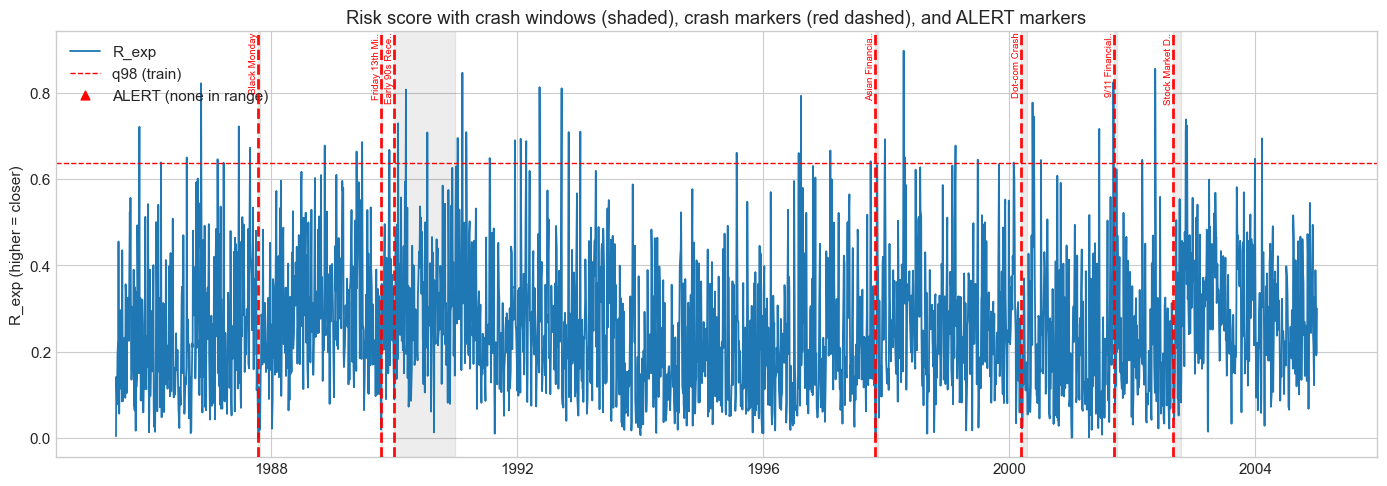

In [143]:


# Settings for validation
LEAD_MAX_DAYS = 90         # how far ahead an alert can count as predicting the crash
MIN_GAP_DAYS = 5            # de-duplicate alert clusters (cooldown)
USE_LEVEL = "level_persist" # column name in `signals` table OR use `level_persist` Series directly


# Build crash event table
crashes = []
for start, end, name in MARKET_EVENTS["crashes"]:
    crashes.append({
        "name": name,
        "start": pd.to_datetime(start),
        "end": pd.to_datetime(end),
    })
crash_df = pd.DataFrame(crashes).sort_values("start").reset_index(drop=True)

# Restrict to your data range (optional)
data_start = signals.index.min()
data_end   = signals.index.max()
crash_df = crash_df[(crash_df["end"] >= data_start) & (crash_df["start"] <= data_end)].copy()

# Extract ALERT timestamps (level==3) and de-duplicate
if isinstance(signals, pd.DataFrame) and USE_LEVEL in signals.columns:
    lvl = signals[USE_LEVEL].copy()
else:
    # if you have a Series named level_persist
    lvl = level_persist.copy()

alerts = lvl[lvl == 3].index.to_series().sort_values()

# Cooldown to avoid counting 10 consecutive-alert days as 10 predictions
if len(alerts) > 0 and MIN_GAP_DAYS is not None and MIN_GAP_DAYS > 0:
    filtered = [alerts.iloc[0]]
    for t in alerts.iloc[1:]:
        if (t - filtered[-1]).days >= MIN_GAP_DAYS:
            filtered.append(t)
    alerts = pd.to_datetime(filtered)

alerts = pd.DatetimeIndex(alerts)

print(f"#alerts (deduped) = {len(alerts)}")
print(f"#crashes in-range = {len(crash_df)}")


# Matching logic
# For each crash: find alerts in (start-LEAD_MAX_DAYS, start)
rows = []
for _, ev in crash_df.iterrows():
    start = ev["start"]
    w0 = start - pd.Timedelta(days=LEAD_MAX_DAYS)
    # alerts strictly before crash start
    cand = alerts[(alerts >= w0) & (alerts < start)]
    if len(cand) == 0:
        rows.append({
            "crash": ev["name"],
            "crash_start": start,
            "hit": False,
            "earliest_alert": pd.NaT,
            "lead_time_days": np.nan,
            "n_alerts_in_window": 0
        })
    else:
        earliest = cand.min()
        rows.append({
            "crash": ev["name"],
            "crash_start": start,
            "hit": True,
            "earliest_alert": earliest,
            "lead_time_days": (start - earliest).days,
            "n_alerts_in_window": len(cand)
        })

crash_match = pd.DataFrame(rows)

# Recall: fraction of crashes hit
recall = crash_match["hit"].mean() if len(crash_match) else np.nan

# Precision: fraction of alerts that match at least one crash within LEAD_MAX_DAYS after alert
# For each alert t, see if exists crash start in (t, t+LEAD_MAX_DAYS]
alert_hits = []
for t in alerts:
    future_crashes = crash_df[(crash_df["start"] > t) & (crash_df["start"] <= t + pd.Timedelta(days=LEAD_MAX_DAYS))]
    alert_hits.append(len(future_crashes) > 0)

alert_hits = np.array(alert_hits, dtype=bool)
precision = alert_hits.mean() if len(alert_hits) else np.nan

# False alarms per year (optional, nice in imbalanced setting)
years = max(1e-9, (data_end - data_start).days / 365.25)
false_alarms_per_year = ((~alert_hits).sum() / years) if len(alert_hits) else np.nan

print("\n=== Validation summary ===")
print(f"Lead window (days): {LEAD_MAX_DAYS}")
print(f"Recall (crashes predicted): {recall:.3f}")
print(f"Precision (alerts that precede a crash): {precision:.3f}")
print(f"False alarms / year: {false_alarms_per_year:.2f}")

display(crash_match)


# Plot: risk + crash windows + ALERT markers
# Choose a plot range 
plot_start = pd.to_datetime("1985-01-02")
plot_end   = pd.to_datetime("2004-12-31")

fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# plot risk if available
if "R_exp" in signals.columns:
    s = signals.loc[plot_start:plot_end, "R_exp"]
    ax.plot(s.index, s.values, lw=1.3, label="R_exp")
ax.axhline(q98, color="red", ls="--", lw=1.0, label="q98 (train)")

# shade crash windows
for _, ev in crash_df.iterrows():
    s = ev["start"]; e = ev["end"]
    if e < plot_start or s > plot_end:
        continue
    ax.axvspan(max(s, plot_start), min(e, plot_end), color="black", alpha=0.07)

# vertical markers at crash start dates + labels (use MARKET_EVENTS so not filtered by crash_df)
ylim = ax.get_ylim()
for start, end, name in MARKET_EVENTS["crashes"]:
    t = pd.to_datetime(start)
    if plot_start <= t <= plot_end:
        ax.axvline(t, color="red", linestyle="--", linewidth=2.0, alpha=0.95, zorder=10)
        short = (name[:14] + "..") if len(name) > 14 else name
        ax.annotate(short, xy=(t, ylim[1]), fontsize=7, rotation=90, va="top", ha="right", color="red")

# mark alerts (ALERT = level 3, deduped)
alert_plot = alerts[(alerts >= plot_start) & (alerts <= plot_end)]
if len(alert_plot) > 0:
    if "R_exp" in signals.columns:
        yvals = signals.loc[alert_plot, "R_exp"].values
        ax.scatter(alert_plot, yvals, color="red", s=40, marker="^", label="ALERT (deduped)", zorder=5, edgecolors="darkred")
    else:
        ax.scatter(alert_plot, np.ones(len(alert_plot)), color="red", s=40, marker="^", label="ALERT (deduped)", zorder=5, edgecolors="darkred")
else:
    ax.scatter([], [], color="red", s=40, marker="^", label="ALERT (none in range)", zorder=5)

ax.set_title("Risk score with crash windows (shaded), crash markers (red dashed), and ALERT markers")
ax.set_ylabel("R_exp (higher = closer)")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()


=== Validation summary (post-2005) ===
#crashes (post-2005): 0
#alerts in period (deduped): 0
Lead window (days): 90
Recall (crashes predicted): nan
Precision (alerts that precede a crash): nan
False alarms / year: nan


""


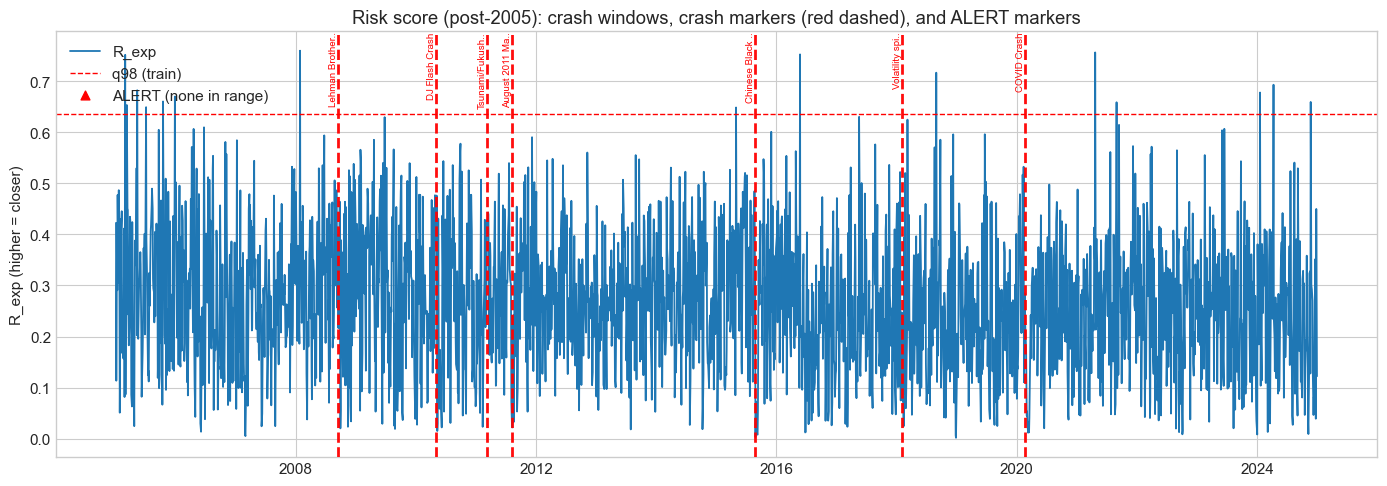

In [142]:
# Validation (post-2005 only): same logic, restricted to out-of-sample period
SPLIT_DATE = pd.Timestamp("2005-01-01")

# Reuse crash_df from previous cell; restrict to post-2005 crashes
crash_df_post = crash_df[crash_df["start"] >= SPLIT_DATE].copy()
# Alerts in post-2005 (for matching and plot)
alerts_post = alerts[alerts >= SPLIT_DATE]
# Use R_exp_full for post-2005 range (signals only has data up to PLOT_END=2004)
data_end_post = R_exp_full.index.max()
data_start_post = SPLIT_DATE

# Matching: for each post-2005 crash, find alerts in (start-LEAD_MAX_DAYS, start)
rows_post = []
for _, ev in crash_df_post.iterrows():
    start = ev["start"]
    w0 = start - pd.Timedelta(days=LEAD_MAX_DAYS)
    cand = alerts[(alerts >= w0) & (alerts < start)]  # all alerts (can be pre-2005) that precede this crash
    if len(cand) == 0:
        rows_post.append({
            "crash": ev["name"],
            "crash_start": start,
            "hit": False,
            "earliest_alert": pd.NaT,
            "lead_time_days": np.nan,
            "n_alerts_in_window": 0
        })
    else:
        earliest = cand.min()
        rows_post.append({
            "crash": ev["name"],
            "crash_start": start,
            "hit": True,
            "earliest_alert": earliest,
            "lead_time_days": (start - earliest).days,
            "n_alerts_in_window": len(cand)
        })

crash_match_post = pd.DataFrame(rows_post)

# Recall (post-2005 crashes only)
recall_post = crash_match_post["hit"].mean() if len(crash_match_post) else np.nan

# Precision: only consider alerts in post-2005; count if they precede a (post-2005) crash
alert_hits_post = []
for t in alerts_post:
    future_crashes = crash_df_post[(crash_df_post["start"] > t) & (crash_df_post["start"] <= t + pd.Timedelta(days=LEAD_MAX_DAYS))]
    alert_hits_post.append(len(future_crashes) > 0)
alert_hits_post = np.array(alert_hits_post, dtype=bool)
precision_post = alert_hits_post.mean() if len(alert_hits_post) else np.nan

years_post = max(1e-9, (data_end_post - data_start_post).days / 365.25)
false_alarms_per_year_post = ((~alert_hits_post).sum() / years_post) if len(alert_hits_post) else np.nan

print("=== Validation summary (post-2005) ===")
print(f"#crashes (post-2005): {len(crash_df_post)}")
print(f"#alerts in period (deduped): {len(alerts_post)}")
print(f"Lead window (days): {LEAD_MAX_DAYS}")
print(f"Recall (crashes predicted): {recall_post:.3f}")
print(f"Precision (alerts that precede a crash): {precision_post:.3f}")
print(f"False alarms / year: {false_alarms_per_year_post:.2f}")
display(crash_match_post)

# Plot: post-2005 risk + crash windows + ALERT markers (use R_exp_full; signals stops at 2004)
plot_start_post = SPLIT_DATE
plot_end_post = data_end_post

fig, ax = plt.subplots(1, 1, figsize=(14, 5))
# R_exp_full has full timeline; signals only has data up to PLOT_END (2004)
s = R_exp_full.loc[plot_start_post:plot_end_post]
ax.plot(s.index, s.values, lw=1.3, label="R_exp")
ax.axhline(q98, color="red", ls="--", lw=1.0, label="q98 (train)")
for _, ev in crash_df_post.iterrows():
    s, e = ev["start"], ev["end"]
    if e < plot_start_post or s > plot_end_post:
        continue
    ax.axvspan(max(s, plot_start_post), min(e, plot_end_post), color="black", alpha=0.07)

# vertical markers at crash start dates + labels (use MARKET_EVENTS, post-2005 only)
ylim_post = ax.get_ylim()
for start, end, name in MARKET_EVENTS["crashes"]:
    t = pd.to_datetime(start)
    if t >= SPLIT_DATE and plot_start_post <= t <= plot_end_post:
        ax.axvline(t, color="red", linestyle="--", linewidth=2.0, alpha=0.95, zorder=10)
        short = (name[:14] + "..") if len(name) > 14 else name
        ax.annotate(short, xy=(t, ylim_post[1]), fontsize=7, rotation=90, va="top", ha="right", color="red")

# mark alerts (ALERT = level 3, deduped)
alert_plot_post = alerts[(alerts >= plot_start_post) & (alerts <= plot_end_post)]
if len(alert_plot_post) > 0:
    yvals = R_exp_full.reindex(alert_plot_post).values
    yvals = np.where(np.isnan(yvals), 1.0, yvals)
    ax.scatter(alert_plot_post, yvals, color="red", s=40, marker="^", label="ALERT (deduped)", zorder=5, edgecolors="darkred")
else:
    ax.scatter([], [], color="red", s=40, marker="^", label="ALERT (none in range)", zorder=5)
ax.set_title("Risk score (post-2005): crash windows, crash markers (red dashed), and ALERT markers")
ax.set_ylabel("R_exp (higher = closer)")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

### D around Dot-com crash

Mahalanobis distance around March 2000.


Min D (pre-2005): 0.10826392131070964
Min D during pre-crash windows:
count    215.000000
mean       1.559631
std        0.745754
min        0.193201
25%        1.085184
50%        1.437758
75%        1.844230
max        4.946747
Name: D_mahal, dtype: float64


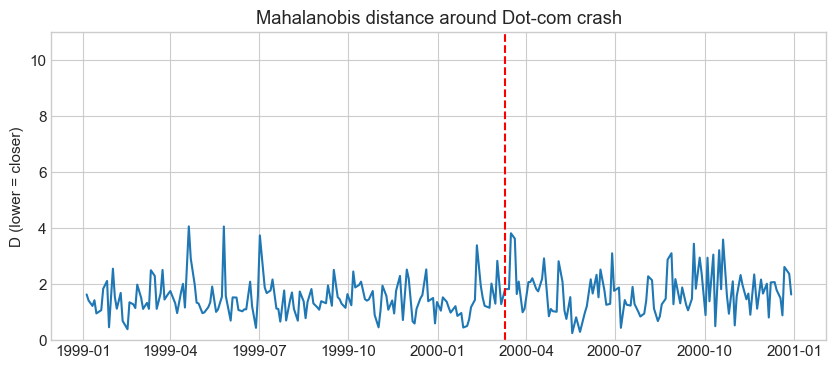

In [125]:
# Mahalonobis distance around Dot-com crash
print("Min D (pre-2005):", D.min())
print("Min D during pre-crash windows:")

mask_pre = build_precrash_mask(D.index, MARKET_EVENTS["crashes"], PRECRASH_L_DAYS)
print(D[mask_pre].describe())

# Plot D around 1987 crash
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(D.loc["1999":"2000"])
plt.axvline(pd.Timestamp("2000-03-10"), color="r", ls="--")
plt.title("Mahalanobis distance around Dot-com crash")
plt.ylabel("D (lower = closer)")
plt.ylim(0, 11)
plt.show()

### D during normal period

Distance during a calm window (1994–1995) for baseline.


Normal-period points: 252
count    252.000000
mean       1.903895
std        0.810660
min        0.414421
25%        1.289485
50%        1.807909
75%        2.457805
max        5.132690
Name: D_mahal, dtype: float64


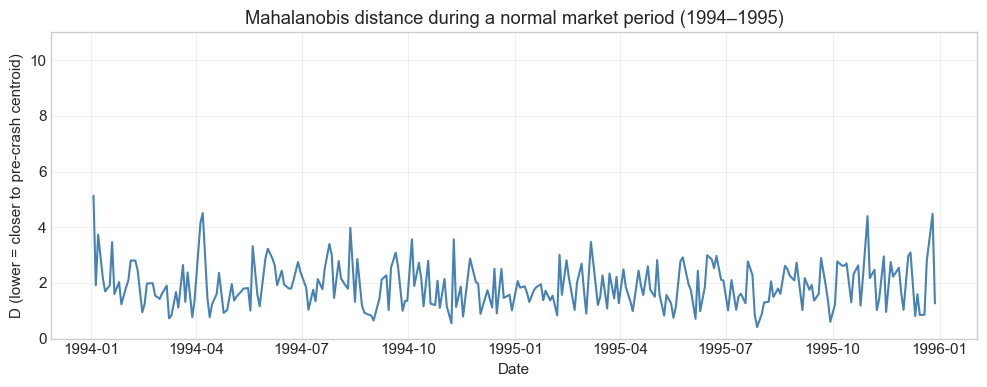

In [126]:

# Choose a NORMAL reference period
# Strategy:
# 1) Exclude all pre-crash windows and crash windows
# 2) Pick a contiguous window of similar length as the crash plot
# 3) Plot D over that window

NORMAL_START = pd.Timestamp("1994-01-01")
NORMAL_END   = pd.Timestamp("1995-12-31")  # ~2 years, quiet market

# Build exclusion masks
mask_pre = build_precrash_mask(D.index, MARKET_EVENTS["crashes"], PRECRASH_L_DAYS)

def build_crash_mask(index, crashes):
    m = pd.Series(False, index=index)
    for start, end, _ in crashes:
        s = pd.to_datetime(start)
        e = pd.to_datetime(end)
        m |= (index >= s) & (index <= e)
    return m

mask_crash = build_crash_mask(D.index, MARKET_EVENTS["crashes"])

mask_normal = (~mask_pre) & (~mask_crash)

# Extract normal-period data
D_normal_period = D.loc[NORMAL_START:NORMAL_END]
D_normal_period = D_normal_period[mask_normal.loc[D_normal_period.index]]

print(f"Normal-period points: {len(D_normal_period)}")
print(D_normal_period.describe())


# Plot: normal period
plt.figure(figsize=(10, 4))
plt.plot(D_normal_period.index, D_normal_period.values, lw=1.5, color="steelblue")
plt.title("Mahalanobis distance during a normal market period (1994–1995)")
plt.ylabel("D (lower = closer to pre-crash centroid)")
plt.xlabel("Date")
plt.ylim(0, 11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Distribution of D

Histograms of D in pre-crash vs normal periods; separation metric.


Counts:
  pre-crash points: 215
  normal points   : 2248

Summary:
  D pre-crash describe:
 count    215.000000
mean       1.559631
std        0.745754
min        0.193201
25%        1.085184
50%        1.437758
75%        1.844230
max        4.946747
Name: D_mahal, dtype: float64

  D normal describe:
 count    2248.000000
mean        1.584552
std         0.806323
min         0.108264
25%         1.053936
50%         1.439475
75%         1.939640
max        10.549793
Name: D_mahal, dtype: float64


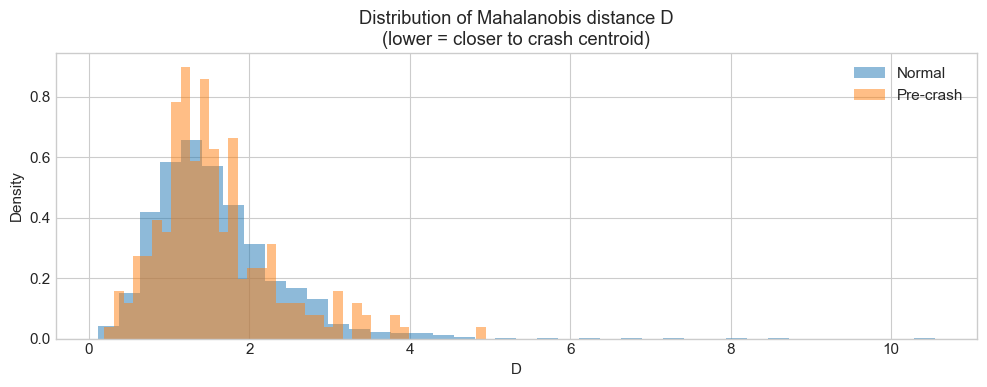


Separation P(D_pre < D_norm): 0.5069022593726723


In [127]:

# Pre-crash mask 
mask_pre = build_precrash_mask(D.index, MARKET_EVENTS["crashes"], PRECRASH_L_DAYS)

D_pre = D[mask_pre].dropna()
D_norm = D[~mask_pre].dropna()

print("Counts:")
print("  pre-crash points:", len(D_pre))
print("  normal points   :", len(D_norm))
print("\nSummary:")
print("  D pre-crash describe:\n", D_pre.describe())
print("\n  D normal describe:\n", D_norm.describe())

# 2) Overlay histograms
plt.figure(figsize=(10,4))
bins = 40
plt.hist(D_norm, bins=bins, alpha=0.5, label="Normal", density=True)
plt.hist(D_pre,  bins=bins, alpha=0.5, label="Pre-crash", density=True)
plt.title("Distribution of Mahalanobis distance D\n(lower = closer to crash centroid)")
plt.xlabel("D")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Separation metric 
# Probability that a random pre-crash point has smaller D than a random normal point.
def auc_like(a, b):
    # a=pre, b=normal; returns P(a<b)
    a = np.asarray(a); b = np.asarray(b)
    return np.mean(a[:,None] < b[None,:])

if len(D_pre) > 0 and len(D_norm) > 0 and len(D_pre)*len(D_norm) <= 2_000_000:
    print("\nSeparation P(D_pre < D_norm):", auc_like(D_pre.values, D_norm.values))
else:
    print("\nSkipping separation calc (too many points).")


### PCA Phase space plot for Dot Com Crash



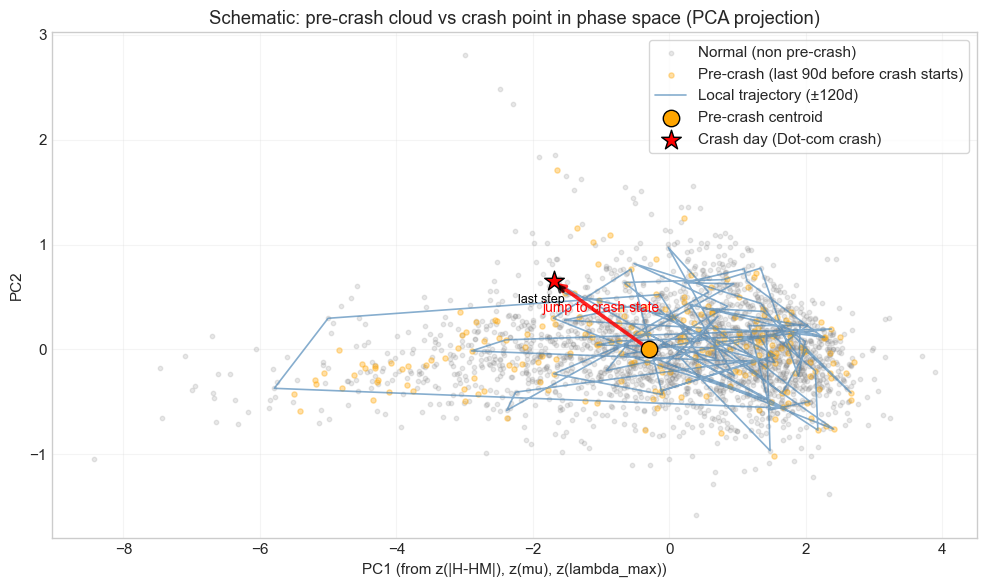

In [144]:

# Parameters 
EVENT_NAME = "Dot-com crash"
CRASH_DAY  = pd.Timestamp("2000-03-10")
WINDOW_DAYS = 120          # window shown around crash for "trajectory + last-step arrow"
PRECRASH_L_DAYS_LOCAL = 90 # pre-crash label window used for the cloud (can match your earlier choice)
USE_TRAIN_ONLY = True
TRAIN_END_LOCAL = pd.Timestamp("2004-12-31")

# Helper function (pca_2d defined in Cell 8)
def pca_2d(X: np.ndarray):
    """Return 2D PCA projection of X using SVD (no sklearn dependency)."""
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    W = Vt[:2].T               # 3x2
    Y = Xc @ W                 # Nx2
    return Y, W, X.mean(axis=0)


# Select data to plot (train-only optional)
X_use = Xdf2[["z_absH", "z_mu", "z_l1"]].dropna().copy()
if USE_TRAIN_ONLY:
    X_use = X_use.loc[:TRAIN_END_LOCAL]

# Create pre-crash mask from your crash list
mask_pre = build_precrash_mask(X_use.index, MARKET_EVENTS["crashes"], PRECRASH_L_DAYS_LOCAL)
mask_norm = ~mask_pre

# Ensure crash day exists (or use nearest)
if CRASH_DAY not in X_use.index:
    # use nearest available timestamp (common when data is in epochs)
    nearest = X_use.index[np.argmin(np.abs((X_use.index - CRASH_DAY).days))]
    print(f"CRASH_DAY {CRASH_DAY.date()} not found; using nearest {nearest.date()}")
    CRASH_DAY = nearest


# PCA projection for schematic readability
Y, W, mean_x = pca_2d(X_use.values)
Ydf = pd.DataFrame(Y, index=X_use.index, columns=["PC1", "PC2"])

# Project pre-crash centroid and crash point
pre_centroid = X_use.loc[mask_pre].mean(axis=0).values
crash_point = X_use.loc[CRASH_DAY].values

def project_point(x):
    # x: (3,) in original space; project into PC space
    xc = x - mean_x
    return xc @ W

pre_centroid_2d = project_point(pre_centroid)
crash_point_2d = project_point(crash_point)


# Last-step velocity arrow into crash (in PC space)
# Take previous point in time as "approach"
prev_idx = X_use.index.get_loc(CRASH_DAY) - 1
if prev_idx < 0:
    prev_day = CRASH_DAY
else:
    prev_day = X_use.index[prev_idx]
prev_point = X_use.loc[prev_day].values
prev_point_2d = project_point(prev_point)


# Optional local trajectory window around crash
t0 = CRASH_DAY - pd.Timedelta(days=WINDOW_DAYS)
t1 = CRASH_DAY + pd.Timedelta(days=WINDOW_DAYS)
traj = Ydf.loc[t0:t1]

# Plot schematic
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Clouds
ax.scatter(Ydf.loc[mask_norm, "PC1"], Ydf.loc[mask_norm, "PC2"],
           s=10, alpha=0.18, color="gray", label="Normal (non pre-crash)")
ax.scatter(Ydf.loc[mask_pre, "PC1"], Ydf.loc[mask_pre, "PC2"],
           s=14, alpha=0.35, color="orange", label=f"Pre-crash (last {PRECRASH_L_DAYS_LOCAL}d before crash starts)")

# Local trajectory around crash (thin line)
if len(traj) > 2:
    ax.plot(traj["PC1"], traj["PC2"], lw=1.2, alpha=0.65, color="steelblue", label=f"Local trajectory (±{WINDOW_DAYS}d)")

# Centroid and crash point
ax.scatter(pre_centroid_2d[0], pre_centroid_2d[1], s=140, color="orange", edgecolor="k", zorder=6, marker="o", label="Pre-crash centroid")
ax.scatter(crash_point_2d[0], crash_point_2d[1], s=220, color="red", edgecolor="k", zorder=7, marker="*", label=f"Crash day ({EVENT_NAME})")

# Arrow: centroid -> crash point (the “jump” schematic)
ax.annotate("",
            xy=(crash_point_2d[0], crash_point_2d[1]),
            xytext=(pre_centroid_2d[0], pre_centroid_2d[1]),
            arrowprops=dict(arrowstyle="->", lw=2.6, color="red", alpha=0.85))
ax.text((pre_centroid_2d[0] + crash_point_2d[0]) / 2,
        (pre_centroid_2d[1] + crash_point_2d[1]) / 2,
        "jump to crash state",
        color="red", fontsize=10, ha="center", va="bottom")

# Arrow: previous -> crash point (last-step approach)
ax.annotate("",
            xy=(crash_point_2d[0], crash_point_2d[1]),
            xytext=(prev_point_2d[0], prev_point_2d[1]),
            arrowprops=dict(arrowstyle="->", lw=2.0, color="black", alpha=0.75))
ax.text(prev_point_2d[0], prev_point_2d[1], "last step", fontsize=9, color="black", ha="right", va="top")

ax.set_title("Schematic: pre-crash cloud vs crash point in phase space (PCA projection)")
ax.set_xlabel("PC1 (from z(|H-HM|), z(mu), z(lambda_max))")
ax.set_ylabel("PC2")
ax.legend(loc="best", frameon=True)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()


### PCA Phase space plot for Black Monday



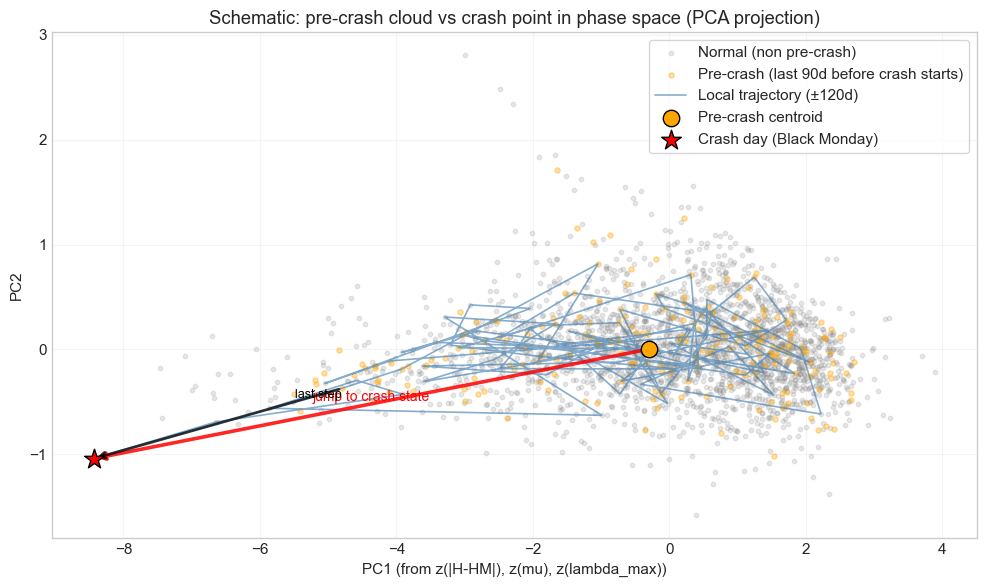

In [145]:

# Parameters 
EVENT_NAME = "Black Monday"
CRASH_DAY  = pd.Timestamp("1987-10-19")
WINDOW_DAYS = 120          # window shown around crash for "trajectory + last-step arrow"
PRECRASH_L_DAYS_LOCAL = 90 # pre-crash label window used for the cloud (can match your earlier choice)
USE_TRAIN_ONLY = True
TRAIN_END_LOCAL = pd.Timestamp("2004-12-31")


# 1) Select data to plot (train-only optional)
X_use = Xdf2[["z_absH", "z_mu", "z_l1"]].dropna().copy()
if USE_TRAIN_ONLY:
    X_use = X_use.loc[:TRAIN_END_LOCAL]

# Create pre-crash mask from your crash list
mask_pre = build_precrash_mask(X_use.index, MARKET_EVENTS["crashes"], PRECRASH_L_DAYS_LOCAL)
mask_norm = ~mask_pre

# Ensure crash day exists (or use nearest)
if CRASH_DAY not in X_use.index:
    # use nearest available timestamp (common when data is in epochs)
    nearest = X_use.index[np.argmin(np.abs((X_use.index - CRASH_DAY).days))]
    print(f"CRASH_DAY {CRASH_DAY.date()} not found; using nearest {nearest.date()}")
    CRASH_DAY = nearest


# 2) PCA projection for schematic readability
Y, W, mean_x = pca_2d(X_use.values)
Ydf = pd.DataFrame(Y, index=X_use.index, columns=["PC1", "PC2"])

# Project pre-crash centroid and crash point
pre_centroid = X_use.loc[mask_pre].mean(axis=0).values
crash_point = X_use.loc[CRASH_DAY].values

def project_point(x):
    # x: (3,) in original space; project into PC space
    xc = x - mean_x
    return xc @ W

pre_centroid_2d = project_point(pre_centroid)
crash_point_2d = project_point(crash_point)


# Last-step velocity arrow into crash (in PC space)
# Take previous point in time as "approach"
prev_idx = X_use.index.get_loc(CRASH_DAY) - 1
if prev_idx < 0:
    prev_day = CRASH_DAY
else:
    prev_day = X_use.index[prev_idx]
prev_point = X_use.loc[prev_day].values
prev_point_2d = project_point(prev_point)


# Local trajectory window around crash

t0 = CRASH_DAY - pd.Timedelta(days=WINDOW_DAYS)
t1 = CRASH_DAY + pd.Timedelta(days=WINDOW_DAYS)
traj = Ydf.loc[t0:t1]

# Plot Shematic
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Clouds
ax.scatter(Ydf.loc[mask_norm, "PC1"], Ydf.loc[mask_norm, "PC2"],
           s=10, alpha=0.18, color="gray", label="Normal (non pre-crash)")
ax.scatter(Ydf.loc[mask_pre, "PC1"], Ydf.loc[mask_pre, "PC2"],
           s=14, alpha=0.35, color="orange", label=f"Pre-crash (last {PRECRASH_L_DAYS_LOCAL}d before crash starts)")

# Local trajectory around crash (thin line)
if len(traj) > 2:
    ax.plot(traj["PC1"], traj["PC2"], lw=1.2, alpha=0.65, color="steelblue", label=f"Local trajectory (±{WINDOW_DAYS}d)")

# Centroid and crash point
ax.scatter(pre_centroid_2d[0], pre_centroid_2d[1], s=140, color="orange", edgecolor="k", zorder=6, marker="o", label="Pre-crash centroid")
ax.scatter(crash_point_2d[0], crash_point_2d[1], s=220, color="red", edgecolor="k", zorder=7, marker="*", label=f"Crash day ({EVENT_NAME})")

# Arrow: centroid -> crash point (the “jump” schematic)
ax.annotate("",
            xy=(crash_point_2d[0], crash_point_2d[1]),
            xytext=(pre_centroid_2d[0], pre_centroid_2d[1]),
            arrowprops=dict(arrowstyle="->", lw=2.6, color="red", alpha=0.85))
ax.text((pre_centroid_2d[0] + crash_point_2d[0]) / 2,
        (pre_centroid_2d[1] + crash_point_2d[1]) / 2,
        "jump to crash state",
        color="red", fontsize=10, ha="center", va="bottom")

# Arrow: previous -> crash point (last-step approach)
ax.annotate("",
            xy=(crash_point_2d[0], crash_point_2d[1]),
            xytext=(prev_point_2d[0], prev_point_2d[1]),
            arrowprops=dict(arrowstyle="->", lw=2.0, color="black", alpha=0.75))
ax.text(prev_point_2d[0], prev_point_2d[1], "last step", fontsize=9, color="black", ha="right", va="top")

ax.set_title("Schematic: pre-crash cloud vs crash point in phase space (PCA projection)")
ax.set_xlabel("PC1 (from z(|H-HM|), z(mu), z(lambda_max))")
ax.set_ylabel("PC2")
ax.legend(loc="best", frameon=True)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

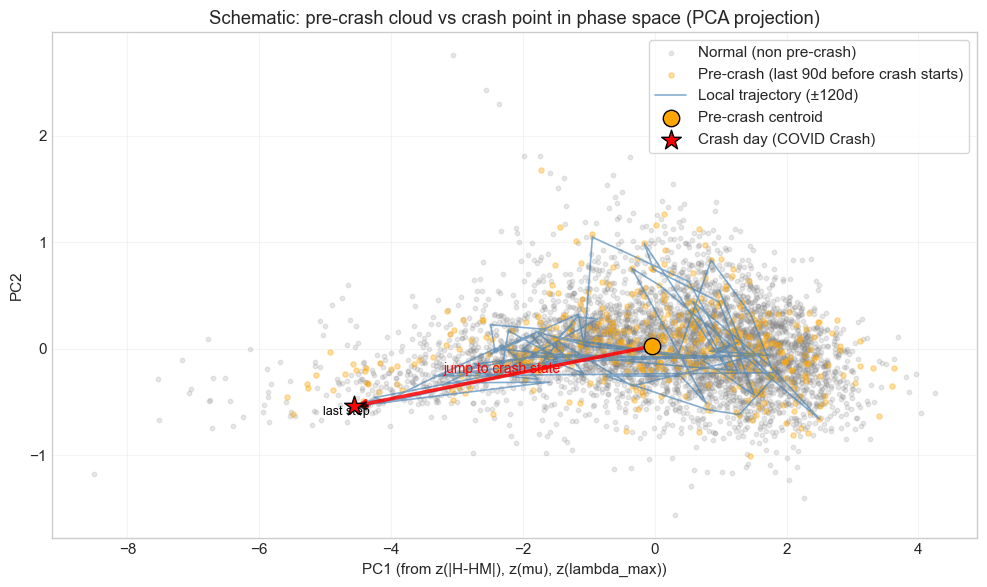

In [146]:
# Parameters 
EVENT_NAME = "COVID Crash"
CRASH_DAY  = pd.Timestamp("2020-03-16")
WINDOW_DAYS = 120          # window shown around crash for "trajectory + last-step arrow"
PRECRASH_L_DAYS_LOCAL = 90 # pre-crash label window used for the cloud (can match your earlier choice)
USE_TRAIN_ONLY = True
TRAIN_END_LOCAL = pd.Timestamp("2024-12-31")


# 1) Select data to plot (train-only optional)
X_use = Xdf2[["z_absH", "z_mu", "z_l1"]].dropna().copy()
if USE_TRAIN_ONLY:
    X_use = X_use.loc[:TRAIN_END_LOCAL]

# Create pre-crash mask from your crash list
mask_pre = build_precrash_mask(X_use.index, MARKET_EVENTS["crashes"], PRECRASH_L_DAYS_LOCAL)
mask_norm = ~mask_pre

# Ensure crash day exists (or use nearest)
if CRASH_DAY not in X_use.index:
    # use nearest available timestamp (common when data is in epochs)
    nearest = X_use.index[np.argmin(np.abs((X_use.index - CRASH_DAY).days))]
    print(f"CRASH_DAY {CRASH_DAY.date()} not found; using nearest {nearest.date()}")
    CRASH_DAY = nearest


# 2) PCA projection for schematic readability
Y, W, mean_x = pca_2d(X_use.values)
Ydf = pd.DataFrame(Y, index=X_use.index, columns=["PC1", "PC2"])

# Project pre-crash centroid and crash point
pre_centroid = X_use.loc[mask_pre].mean(axis=0).values
crash_point = X_use.loc[CRASH_DAY].values

def project_point(x):
    # x: (3,) in original space; project into PC space
    xc = x - mean_x
    return xc @ W

pre_centroid_2d = project_point(pre_centroid)
crash_point_2d = project_point(crash_point)


# Last-step velocity arrow into crash (in PC space)
# Take previous point in time as "approach"
prev_idx = X_use.index.get_loc(CRASH_DAY) - 1
if prev_idx < 0:
    prev_day = CRASH_DAY
else:
    prev_day = X_use.index[prev_idx]
prev_point = X_use.loc[prev_day].values
prev_point_2d = project_point(prev_point)


# Local trajectory window around crash

t0 = CRASH_DAY - pd.Timedelta(days=WINDOW_DAYS)
t1 = CRASH_DAY + pd.Timedelta(days=WINDOW_DAYS)
traj = Ydf.loc[t0:t1]

# Plot Shematic
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Clouds
ax.scatter(Ydf.loc[mask_norm, "PC1"], Ydf.loc[mask_norm, "PC2"],
           s=10, alpha=0.18, color="gray", label="Normal (non pre-crash)")
ax.scatter(Ydf.loc[mask_pre, "PC1"], Ydf.loc[mask_pre, "PC2"],
           s=14, alpha=0.35, color="orange", label=f"Pre-crash (last {PRECRASH_L_DAYS_LOCAL}d before crash starts)")

# Local trajectory around crash (thin line)
if len(traj) > 2:
    ax.plot(traj["PC1"], traj["PC2"], lw=1.2, alpha=0.65, color="steelblue", label=f"Local trajectory (±{WINDOW_DAYS}d)")

# Centroid and crash point
ax.scatter(pre_centroid_2d[0], pre_centroid_2d[1], s=140, color="orange", edgecolor="k", zorder=6, marker="o", label="Pre-crash centroid")
ax.scatter(crash_point_2d[0], crash_point_2d[1], s=220, color="red", edgecolor="k", zorder=7, marker="*", label=f"Crash day ({EVENT_NAME})")

# Arrow: centroid -> crash point (the “jump” schematic)
ax.annotate("",
            xy=(crash_point_2d[0], crash_point_2d[1]),
            xytext=(pre_centroid_2d[0], pre_centroid_2d[1]),
            arrowprops=dict(arrowstyle="->", lw=2.6, color="red", alpha=0.85))
ax.text((pre_centroid_2d[0] + crash_point_2d[0]) / 2,
        (pre_centroid_2d[1] + crash_point_2d[1]) / 2,
        "jump to crash state",
        color="red", fontsize=10, ha="center", va="bottom")

# Arrow: previous -> crash point (last-step approach)
ax.annotate("",
            xy=(crash_point_2d[0], crash_point_2d[1]),
            xytext=(prev_point_2d[0], prev_point_2d[1]),
            arrowprops=dict(arrowstyle="->", lw=2.0, color="black", alpha=0.75))
ax.text(prev_point_2d[0], prev_point_2d[1], "last step", fontsize=9, color="black", ha="right", va="top")

ax.set_title("Schematic: pre-crash cloud vs crash point in phase space (PCA projection)")
ax.set_xlabel("PC1 (from z(|H-HM|), z(mu), z(lambda_max))")
ax.set_ylabel("PC2")
ax.legend(loc="best", frameon=True)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

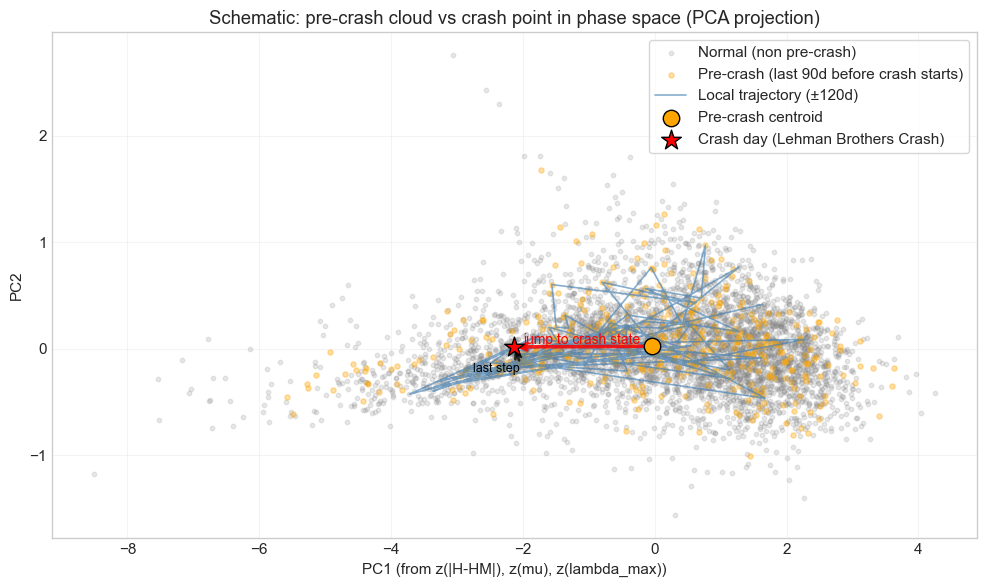

In [149]:
# Parameters for Lehman (2008) crash schematic
EVENT_NAME = "Lehman Brothers Crash"
CRASH_DAY  = pd.Timestamp("2008-09-15")
WINDOW_DAYS = 120         # window shown around crash for "trajectory + last-step arrow"
PRECRASH_L_DAYS_LOCAL = 90 # pre-crash label window used for the cloud
USE_TRAIN_ONLY = True
TRAIN_END_LOCAL = pd.Timestamp("2024-12-31")


# 1) Select data to plot (train-only optional)
X_use = Xdf2[["z_absH", "z_mu", "z_l1"]].dropna().copy()
if USE_TRAIN_ONLY:
    X_use = X_use.loc[:TRAIN_END_LOCAL]

# Create pre-crash mask from your crash list
mask_pre = build_precrash_mask(X_use.index, MARKET_EVENTS["crashes"], PRECRASH_L_DAYS_LOCAL)
mask_norm = ~mask_pre

# Ensure crash day exists (or use nearest)
if CRASH_DAY not in X_use.index:
    # use nearest available timestamp (common when data is in epochs)
    nearest = X_use.index[np.argmin(np.abs((X_use.index - CRASH_DAY).days))]
    print(f"CRASH_DAY {CRASH_DAY.date()} not found; using nearest {nearest.date()}")
    CRASH_DAY = nearest


# 2) PCA projection for schematic readability
Y, W, mean_x = pca_2d(X_use.values)
Ydf = pd.DataFrame(Y, index=X_use.index, columns=["PC1", "PC2"])

# Project pre-crash centroid and crash point
pre_centroid = X_use.loc[mask_pre].mean(axis=0).values
crash_point = X_use.loc[CRASH_DAY].values

def project_point(x):
    # x: (3,) in original space; project into PC space
    xc = x - mean_x
    return xc @ W

pre_centroid_2d = project_point(pre_centroid)
crash_point_2d = project_point(crash_point)


# Last-step velocity arrow into crash (in PC space)
# Take previous point in time as "approach"
prev_idx = X_use.index.get_loc(CRASH_DAY) - 1
if prev_idx < 0:
    prev_day = CRASH_DAY
else:
    prev_day = X_use.index[prev_idx]
prev_point = X_use.loc[prev_day].values
prev_point_2d = project_point(prev_point)


# Local trajectory window around crash

t0 = CRASH_DAY - pd.Timedelta(days=WINDOW_DAYS)
t1 = CRASH_DAY + pd.Timedelta(days=WINDOW_DAYS)
traj = Ydf.loc[t0:t1]

# Plot Shematic
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Clouds
ax.scatter(Ydf.loc[mask_norm, "PC1"], Ydf.loc[mask_norm, "PC2"],
           s=10, alpha=0.18, color="gray", label="Normal (non pre-crash)")
ax.scatter(Ydf.loc[mask_pre, "PC1"], Ydf.loc[mask_pre, "PC2"],
           s=14, alpha=0.35, color="orange", label=f"Pre-crash (last {PRECRASH_L_DAYS_LOCAL}d before crash starts)")

# Local trajectory around crash (thin line)
if len(traj) > 2:
    ax.plot(traj["PC1"], traj["PC2"], lw=1.2, alpha=0.65, color="steelblue", label=f"Local trajectory (±{WINDOW_DAYS}d)")

# Centroid and crash point
ax.scatter(pre_centroid_2d[0], pre_centroid_2d[1], s=140, color="orange", edgecolor="k", zorder=6, marker="o", label="Pre-crash centroid")
ax.scatter(crash_point_2d[0], crash_point_2d[1], s=220, color="red", edgecolor="k", zorder=7, marker="*", label=f"Crash day ({EVENT_NAME})")

# Arrow: centroid -> crash point (the “jump” schematic)
ax.annotate("",
            xy=(crash_point_2d[0], crash_point_2d[1]),
            xytext=(pre_centroid_2d[0], pre_centroid_2d[1]),
            arrowprops=dict(arrowstyle="->", lw=2.6, color="red", alpha=0.85))
ax.text((pre_centroid_2d[0] + crash_point_2d[0]) / 2,
        (pre_centroid_2d[1] + crash_point_2d[1]) / 2,
        "jump to crash state",
        color="red", fontsize=10, ha="center", va="bottom")

# Arrow: previous -> crash point (last-step approach)
ax.annotate("",
            xy=(crash_point_2d[0], crash_point_2d[1]),
            xytext=(prev_point_2d[0], prev_point_2d[1]),
            arrowprops=dict(arrowstyle="->", lw=2.0, color="black", alpha=0.75))
ax.text(prev_point_2d[0], prev_point_2d[1], "last step", fontsize=9, color="black", ha="right", va="top")

ax.set_title("Schematic: pre-crash cloud vs crash point in phase space (PCA projection)")
ax.set_xlabel("PC1 (from z(|H-HM|), z(mu), z(lambda_max))")
ax.set_ylabel("PC2")
ax.legend(loc="best", frameon=True)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

### Event-aligned D

Mahalanobis distance aligned at crash start; median and IQR.


Normal reference (global) median=1.447, IQR=[1.070, 1.948] (N=2143)
Included crashes in aggregation: 7 / 14


,crash,start,points_in_window,median_D_pre60,median_D_post60,max_D_0to7
0,Black Monday,1987-10-19,241,1.149058,1.587696,10.549793
1,Friday 13th Mini Crash,1989-10-13,241,1.487485,1.097701,3.962845
2,Early 90s Recession,1990-01-01,241,1.043351,1.280814,2.416337
3,Asian Financial Crisis,1997-10-27,241,1.536371,1.195611,8.635828
4,Dot-com Crash,2000-03-10,241,1.225369,1.827706,3.817207
5,9/11 Financial Crisis,2001-09-11,240,1.505653,1.690645,1.797980
6,Stock Market Downturn 2002,2002-09-01,241,1.597934,1.572409,3.132181


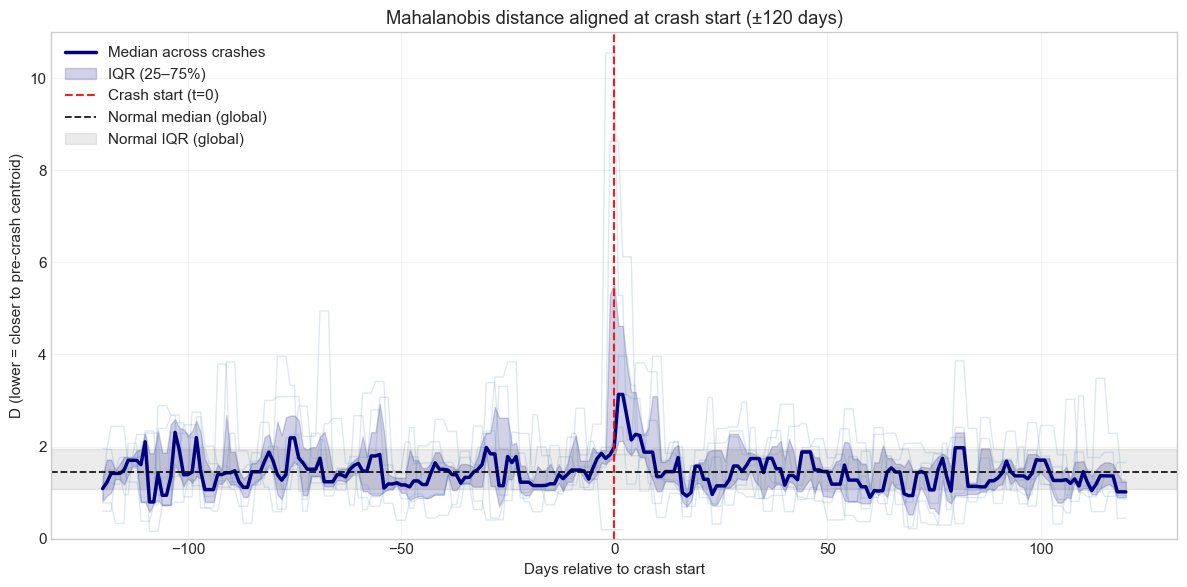

In [130]:
# --- Event-aligned Mahalanobis distance across crashes + "normal-period" reference band ---
# Adds a reference distribution from NORMAL periods (times not in any pre-crash window and not in crash windows),
# shown as:
#   (A) horizontal dashed lines at the normal median and IQR
#   (B) optional normalization of each crash curve by its own pre-window median (already supported)



# Settings
ALIGN_WINDOW_DAYS = 120
RESAMPLE = "D"
MIN_POINTS = 30
NORMALIZE = False

# Normal reference construction
PRECRASH_L_DAYS_REF = 60    # pre-crash mask width 
EXCLUDE_CRASH_DAYS = True    # also exclude crash windows themselves from "normal"
USE_TRAIN_ONLY_FOR_NORMAL = True
TRAIN_END_LOCAL = pd.Timestamp("2004-12-31")


# Helpers
def build_crashwindow_mask(index: pd.DatetimeIndex, crashes) -> pd.Series:
    mask = pd.Series(False, index=index)
    for start, end, name in crashes:
        s = pd.to_datetime(start)
        e = pd.to_datetime(end)
        mask |= (index >= s) & (index <= e)
    return mask


# Data + event list
crash_events = [(pd.to_datetime(s), pd.to_datetime(e), name) for s, e, name in MARKET_EVENTS["crashes"]]
crash_events = sorted(crash_events, key=lambda x: x[0])

D_use = D.dropna().sort_index()
if USE_TRAIN_ONLY_FOR_NORMAL:
    D_use_for_normal = D_use.loc[:TRAIN_END_LOCAL].copy()
else:
    D_use_for_normal = D_use.copy()

# Normal reference distribution (global, not aligned)
mask_pre_ref = build_precrash_mask(D_use_for_normal.index, MARKET_EVENTS["crashes"], PRECRASH_L_DAYS_REF)
mask_norm_ref = ~mask_pre_ref

if EXCLUDE_CRASH_DAYS:
    mask_crash = build_crashwindow_mask(D_use_for_normal.index, MARKET_EVENTS["crashes"])
    mask_norm_ref &= ~mask_crash

D_normal_ref = D_use_for_normal.loc[mask_norm_ref].dropna()

if len(D_normal_ref) < 50:
    print("Warning: very few normal reference points; consider setting USE_TRAIN_ONLY_FOR_NORMAL=False "
          "or EXCLUDE_CRASH_DAYS=False, or increasing your data range.")

norm_med = D_normal_ref.median()
norm_q25 = D_normal_ref.quantile(0.25)
norm_q75 = D_normal_ref.quantile(0.75)

print(f"Normal reference (global) median={norm_med:.3f}, IQR=[{norm_q25:.3f}, {norm_q75:.3f}] "
      f"(N={len(D_normal_ref)})")

# Build aligned matrix: rows = relative day, cols = crash
t_grid = pd.timedelta_range(start=-pd.Timedelta(days=ALIGN_WINDOW_DAYS),
                            end=pd.Timedelta(days=ALIGN_WINDOW_DAYS),
                            freq=RESAMPLE)
rel_days = np.array([td.days for td in t_grid], dtype=int)

aligned = {}
meta_rows = []

for start, end, name in crash_events:
    w0 = start - pd.Timedelta(days=ALIGN_WINDOW_DAYS)
    w1 = start + pd.Timedelta(days=ALIGN_WINDOW_DAYS)

    seg = D_use.loc[w0:w1].copy()

    if RESAMPLE is not None:
        seg = seg.reindex(pd.date_range(w0, w1, freq=RESAMPLE),
                          method="nearest",
                          tolerance=pd.Timedelta(days=3))

    seg_rel = (seg.index - start).days
    seg.index = seg_rel

    y = pd.Series(index=rel_days, dtype=float)
    y.loc[seg.index.intersection(rel_days)] = seg.values

    npts = y.notna().sum()
    if npts < MIN_POINTS:
        continue

    if NORMALIZE:
        baseline = y.loc[-ALIGN_WINDOW_DAYS:-1].median()
        if np.isfinite(baseline) and baseline > 0:
            y = y / baseline

    aligned[name] = y

    pre_med = y.loc[-60:-1].median()
    post_med = y.loc[0:60].median()
    spike = y.loc[0:7].max()
    meta_rows.append({
        "crash": name,
        "start": start.date(),
        "points_in_window": int(npts),
        "median_D_pre60": float(pre_med) if np.isfinite(pre_med) else np.nan,
        "median_D_post60": float(post_med) if np.isfinite(post_med) else np.nan,
        "max_D_0to7": float(spike) if np.isfinite(spike) else np.nan,
    })

aligned_df = pd.DataFrame(aligned)
summary_df = pd.DataFrame(meta_rows).sort_values("start")

print(f"Included crashes in aggregation: {aligned_df.shape[1]} / {len(crash_events)}")
display(summary_df)


# Aggregate statistics (median + IQR)
median = aligned_df.median(axis=1, skipna=True)
q25 = aligned_df.quantile(0.25, axis=1, interpolation="linear")
q75 = aligned_df.quantile(0.75, axis=1, interpolation="linear")

# If normalized, also normalize reference band accordingly (not well-defined globally).
show_ref = (not NORMALIZE)


# Plot 1: Overlay all aligned curves + median/IQR + normal reference band
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for col in aligned_df.columns:
    ax.plot(aligned_df.index, aligned_df[col].values, color="steelblue", alpha=0.18, lw=1.0)

ax.plot(median.index, median.values, color="navy", lw=2.5, label="Median across crashes")
ax.fill_between(median.index, q25.values, q75.values, color="navy", alpha=0.18, label="IQR (25–75%)")

ax.axvline(0, color="red", ls="--", lw=1.5, alpha=0.9, label="Crash start (t=0)")

if show_ref:
    ax.axhline(norm_med, color="black", ls="--", lw=1.3, alpha=0.9, label="Normal median (global)")
    ax.axhspan(norm_q25, norm_q75, color="black", alpha=0.08, label="Normal IQR (global)")

ax.set_title(f"Mahalanobis distance aligned at crash start (±{ALIGN_WINDOW_DAYS} days)"
             + (" [normalized]" if NORMALIZE else ""))
ax.set_xlabel("Days relative to crash start")
ax.set_ylabel("D (lower = closer to pre-crash centroid)" + (" / baseline" if NORMALIZE else ""))
ax.legend(loc="upper left")
plt.ylim(0, 11)
ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()



### D around Black Monday

Mahalanobis distance in the period around October 1987.


Min D (pre-2005): 0.10826392131070964
Min D during pre-crash windows:
count    215.000000
mean       1.559631
std        0.745754
min        0.193201
25%        1.085184
50%        1.437758
75%        1.844230
max        4.946747
Name: D_mahal, dtype: float64


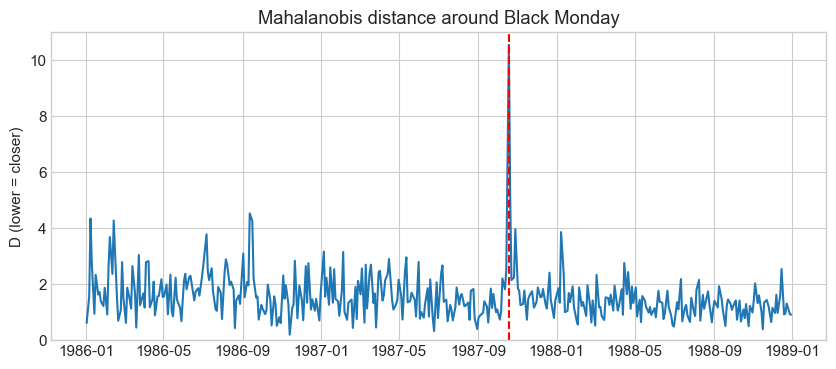

In [131]:
# Diagnostic
print("Min D (pre-2005):", D.min())
print("Min D during pre-crash windows:")

mask_pre = build_precrash_mask(D.index, MARKET_EVENTS["crashes"], PRECRASH_L_DAYS)
print(D[mask_pre].describe())

# Plot D around 1987 crash
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(D.loc["1986":"1988"])
plt.axvline(pd.Timestamp("1987-10-19"), color="r", ls="--")
plt.title("Mahalanobis distance around Black Monday")
plt.ylabel("D (lower = closer)")
plt.ylim(0, 11)
plt.show()

### Code

See code below.


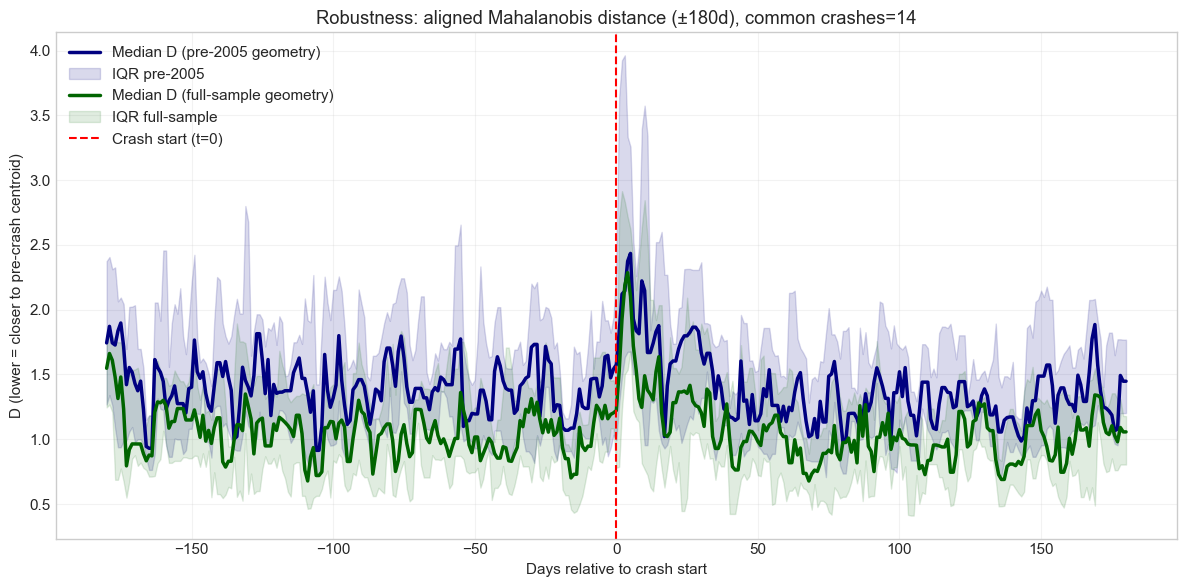

In [137]:
# --- Robustness check: "full-sample geometry" vs "pre-2005 geometry" ---


# Settings

PRECRASH_L_DAYS = 60         
ALIGN_WINDOW_DAYS = 180
RESAMPLE = "D"
MIN_POINTS = 30

# Pre-2005 geometry over full timeline so all crashes (incl. post-2005) are included
D_PRE = D_full



def aligned_event_matrix(series: pd.Series, crashes, window_days=180, resample="D", min_points=30):
    """Return aligned_df (rows=relative day, cols=crash name) and per-crash summary."""
    series = series.dropna().sort_index()
    events = [(pd.to_datetime(s), pd.to_datetime(e), name) for s, e, name in crashes]
    events = sorted(events, key=lambda x: x[0])

    t_grid = pd.timedelta_range(start=-pd.Timedelta(days=window_days),
                                end=pd.Timedelta(days=window_days),
                                freq=resample)
    rel_days = np.array([td.days for td in t_grid], dtype=int)

    aligned = {}
    meta = []
    for start, end, name in events:
        w0 = start - pd.Timedelta(days=window_days)
        w1 = start + pd.Timedelta(days=window_days)

        seg = series.loc[w0:w1].copy()
        if resample is not None:
            seg = seg.reindex(pd.date_range(w0, w1, freq=resample),
                              method="nearest",
                              tolerance=pd.Timedelta(days=3))

        seg_rel = (seg.index - start).days
        seg.index = seg_rel

        y = pd.Series(index=rel_days, dtype=float)
        y.loc[seg.index.intersection(rel_days)] = seg.values

        npts = int(y.notna().sum())
        if npts < min_points:
            continue

        aligned[name] = y
        meta.append({"crash": name, "start": start.date(), "points_in_window": npts})

    return pd.DataFrame(aligned), pd.DataFrame(meta).sort_values("start")


# Fit FULL-sample crash geometry (centroid/cov) from pre-crash windows

X_all = Xdf2[["z_absH", "z_mu", "z_l1"]].dropna().copy()

mask_pre_all = build_precrash_mask(X_all.index, MARKET_EVENTS["crashes"], PRECRASH_L_DAYS)
X_pre_all = X_all.loc[mask_pre_all]

if len(X_pre_all) < 30:
    raise ValueError(f"Too few pre-crash points in full sample: {len(X_pre_all)}")

mu_full = X_pre_all.mean(axis=0).values
Sigma_full = np.cov(X_pre_all.values.T)

# Shrinkage (same style as your robustness plot) for stability
alpha = 0.3
Sigma_diag = np.diag(np.diag(Sigma_full))
Sigma_full_shrunk = (1 - alpha) * Sigma_full + alpha * Sigma_diag
Sigma_inv_full = np.linalg.inv(Sigma_full_shrunk + 1e-8 * np.eye(3))

# Compute D under FULL-sample geometry
D_FULL = pd.Series(
    mahalanobis_distance(X_all.values, mu_full, Sigma_inv_full),
    index=X_all.index,
    name=f"D_fullgeom_shrunk_a{alpha}"
)

# Build aligned matrices for PRE-geom and FULL-geom distances

aligned_pre, meta_pre = aligned_event_matrix(D_PRE, MARKET_EVENTS["crashes"],
                                            window_days=ALIGN_WINDOW_DAYS, resample=RESAMPLE,
                                            min_points=MIN_POINTS)
aligned_full, meta_full = aligned_event_matrix(D_FULL, MARKET_EVENTS["crashes"],
                                              window_days=ALIGN_WINDOW_DAYS, resample=RESAMPLE,
                                              min_points=MIN_POINTS)

# Use only crashes present in BOTH matrices
common = sorted(set(aligned_pre.columns).intersection(aligned_full.columns))
aligned_pre = aligned_pre[common]
aligned_full = aligned_full[common]

med_pre = aligned_pre.median(axis=1, skipna=True)
q25_pre = aligned_pre.quantile(0.25, axis=1)
q75_pre = aligned_pre.quantile(0.75, axis=1)

med_full = aligned_full.median(axis=1, skipna=True)
q25_full = aligned_full.quantile(0.25, axis=1)
q75_full = aligned_full.quantile(0.75, axis=1)


# Plot: median + IQR for both geometries

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# PRE-2005 geometry (baseline)
ax.plot(med_pre.index, med_pre.values, color="navy", lw=2.5, label="Median D (pre-2005 geometry)")
ax.fill_between(med_pre.index, q25_pre.values, q75_pre.values, color="navy", alpha=0.15, label="IQR pre-2005")

# FULL-sample geometry (robustness)
ax.plot(med_full.index, med_full.values, color="darkgreen", lw=2.5, label="Median D (full-sample geometry)")
ax.fill_between(med_full.index, q25_full.values, q75_full.values, color="darkgreen", alpha=0.12, label="IQR full-sample")

ax.axvline(0, color="red", ls="--", lw=1.5, label="Crash start (t=0)")
ax.set_title(f"Robustness: aligned Mahalanobis distance (±{ALIGN_WINDOW_DAYS}d), common crashes={len(common)}")
ax.set_xlabel("Days relative to crash start")
ax.set_ylabel("D (lower = closer to pre-crash centroid)")
ax.grid(True, alpha=0.25)
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

